## Exploring the data

Download the Wikipedia dataset + randomly sample sentences as input

In [1]:
# load dataset
from datasets import load_dataset

dataset = load_dataset("wiki_auto")

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No config specified, defaulting to: wiki_auto/auto
Reusing dataset wiki_auto (/n/home10/cyeh/.cache/huggingface/datasets/wiki_auto/auto/1.0.0/eeac705719dc9aa2ff180571dfed6c6649588ccdfde8d45a47d2e47e5c5b93af)
100%|██████████| 2/2 [00:00<00:00, 65.96it/s]


In [2]:
# remove data points with no examples
data = [dataset['part_1'][i]['normal']['normal_article_content']['normal_sentence'] for i in range(len(dataset['part_1'])) if len(dataset['part_1'][i]['normal']['normal_article_content']['normal_sentence']) != 0] 

In [3]:
# now see how many data points there are
data_len = len(data)
data_len

124913

In [4]:
# choose 1000 random data points to sample from
import random
num_examples = 1000
random.seed(10) # set seed
indices = random.sample(range(data_len), num_examples)
indices[:10]

[74894, 4270, 56215, 63250, 75771, 1944, 27013, 60631, 106603, 64395]

In [5]:
# get one sentence for each selected data point
sentences = []
for i in indices:
    # get all sentences associated with data point
    sentence_list = data[i]
    sentence = random.choice(sentence_list) # choose random sentence from list
    sentences.append(sentence)

sentences[:10]

['Synthpop band Freezepop have used it on stage.',
 "Plumb was awarded a knighthood in the Queen's Birthday Honours list in 1973.",
 'He read and memorized the entire Quran by the time he was nine years old.',
 "Some other yearly festivals are Paris-Plages, a festive event that lasts from mid-July to mid-August when the Right Bank of the Seine is converted into a temporary beach with sand, deck chairs and palm trees; Journées du Patrimoine, Fête de la Musique, Techno Parade, Nuit Blanche, Cinéma au clair de lune, Printemps des rues, Festival d'automne, and Fête des jardins.",
 'Despite this decision, many Church of the East Old Calendarists rejected the move so in an attempt to avert further dissent, the Holy Synod maintained that Easter would continue to be celebrated according to the Julian Calendar.',
 "On a difficult, slow pitch at Port Elizabeth, Australia struggled their way to 212 (7 wickets, 50 overs) against tight Sri Lankan bowling, thanks mainly to a great innings from A

### archive

In [ ]:
# find where sentences are located
dataset['part_1'][0]['normal']['normal_article_content']['normal_sentence']

In [ ]:
# see how many data points there are
data_len = len(dataset['part_1'])
data_len

## Running BERT

Just seeing the basic output from BERT with 2 sentences

In [1]:
# load model
from transformers import BertTokenizer, BertModel, GPT2Model, GPT2Tokenizer
import torch
import numpy as np
from numpy.linalg import norm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
# from sklearn.decomposition import PCA

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# GPT check
# model_version = 'gpt2'
# model = GPT2Model.from_pretrained(model_version, output_attentions=True)
# tokenizer = GPT2Tokenizer.from_pretrained(model_version)

model_type = 'bert'
model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=True)

# print(model.h[0].attn.c_attn.bias)

#check out parameters
for name, param in model.named_parameters():                
    print(name, param.size())

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


embeddings.word_embeddings.weight torch.Size([30522, 768])
embeddings.position_embeddings.weight torch.Size([512, 768])
embeddings.token_type_embeddings.weight torch.Size([2, 768])
embeddings.LayerNorm.weight torch.Size([768])
embeddings.LayerNorm.bias torch.Size([768])
encoder.layer.0.attention.self.query.weight torch.Size([768, 768])
encoder.layer.0.attention.self.query.bias torch.Size([768])
encoder.layer.0.attention.self.key.weight torch.Size([768, 768])
encoder.layer.0.attention.self.key.bias torch.Size([768])
encoder.layer.0.attention.self.value.weight torch.Size([768, 768])
encoder.layer.0.attention.self.value.bias torch.Size([768])
encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
encoder.layer.0.attention.output.dense.bias torch.Size([768])
encoder.layer.0.attention.output.LayerNorm.weight torch.Size([768])
encoder.layer.0.attention.output.LayerNorm.bias torch.Size([768])
encoder.layer.0.intermediate.dense.weight torch.Size([3072, 768])
encoder.layer.0.inter

### Position experiment

In [ ]:
# GPT
positions = model.wpe.weight 
unit_vecs = []
for pos in positions:
    pos = pos.detach().numpy()
    unit = pos / norm(pos)
    unit_vecs.append(unit)

In [ ]:
new_norms_q = {}
new_norms_k = {}

max_norm = 0

# initialize list of norms
for layer in range(12):
    for head in range(12):
        new_norms_q[(layer, head)] = []
        new_norms_k[(layer, head)] = []
        
    
# compute new norms    
for pos in range(20):
    for layer in range(12):
        for head in range(12):
            q = get_weights(query_weights, layer, head)
            k = get_weights(key_weights, layer, head)
            
            q_transformed = unit_vecs[pos] @ q
            k_transformed = unit_vecs[pos] @ k

            norm_q = norm(q_transformed)
            norm_k = norm(k_transformed)
            
            if norm_q > max_norm:
                max_norm = norm_q
            if norm_k > max_norm:
                max_norm = norm_k

            new_norms_q[(layer, head)].append(norm_q)
            new_norms_k[(layer, head)].append(norm_k)

In [ ]:
print(max_norm)

In [ ]:
fig, axs = plt.subplots(12, 12)
for layer in range(12):
    for head in range(12):
        ax = axs[layer, head]
        ax.plot(new_norms_q[(layer, head)], c='#2bcc91')
        ax.plot(new_norms_k[(layer, head)], c='#fc47a5')
        ax.set_title("L{} H{}".format(layer, head), fontsize=14)
        ax.set_ylim(0, 5)
        ax.set_xlim(0, 20)
        
fig.suptitle('Positional Impact on Query/Key Norms in GPT', fontsize=16, y=1)
fig.set_size_inches(20, 18)
fig.tight_layout(pad=0.8)
fig.text(0.5, -0.01, 'Position', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'Norm', va='center', rotation='vertical', fontsize=16)
plt.show()

In [ ]:
# BERT
positions = model.embeddings.position_embeddings.weight
unit_vecs = []
for pos in positions:
    pos = pos.detach().numpy()
    unit = pos / norm(pos)
    unit_vecs.append(unit)

In [ ]:
new_norms_q = {}
new_norms_k = {}
max_norm = 0

# initialize list of norms
for layer in range(12):
    for head in range(12):
        new_norms_q[(layer, head)] = []
        new_norms_k[(layer, head)] = []
    
# compute new norms    
for pos in range(20):
    for layer in range(12):
        for head in range(12):
            q = get_weights(query_weights, layer, head)
            k = get_weights(key_weights, layer, head)
            
            q_transformed = unit_vecs[pos] @ q
            k_transformed = unit_vecs[pos] @ k

            norm_q = norm(q_transformed)
            norm_k = norm(k_transformed)
            
            if norm_q > max_norm:
                max_norm = norm_q
            if norm_k > max_norm:
                max_norm = norm_k

            new_norms_q[(layer, head)].append(norm_q)
            new_norms_k[(layer, head)].append(norm_k)

In [ ]:
print(max_norm)

In [ ]:
fig, axs = plt.subplots(12, 12)
for layer in range(12):
    for head in range(12):
        ax = axs[layer, head]
        ax.plot(new_norms_q[(layer, head)], c='#2bcc91')
        ax.plot(new_norms_k[(layer, head)], c='#fc47a5')
        ax.set_title("L{} H{}".format(layer, head), fontsize=14)
        ax.set_ylim(0, 20)
        ax.set_xlim(0, 20)
        
fig.suptitle('Positional Impact on Query/Key Norms in BERT', fontsize=16, y=1)
fig.set_size_inches(20, 18)
fig.tight_layout(pad=0.8)
fig.text(0.5, -0.01, 'Position', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'Norm', va='center', rotation='vertical', fontsize=16)
plt.show()

### Frob Norm distance experiment

#### GPT

In [10]:
### get dot products of weights
gpt_dp = []
for layer in range(12):
    for head in range(12):
        qw = get_weights(query_weights, layer, head)
        kw = get_weights(key_weights, layer, head)
        
        qw = np.asarray(qw)
        kw = np.asarray(kw)
        
        dp = np.dot(qw, kw.transpose())
        
        gpt_dp.append(dp)

In [11]:
gpt_dp = [weights.flatten() for weights in gpt_dp]    

In [12]:
print(gpt_dp[0])

[-1.1234171   1.3737348  -0.28326795 ...  0.8513974  -0.2996441
 -1.2570856 ]


#### BERT

In [15]:
### get dot products of weights
bert_dp = []
for layer in range(12):
    for head in range(12):
        qw = get_weights(query_weights, layer, head)
        kw = get_weights(key_weights, layer, head)
        
        qw = np.asarray(qw)
        kw = np.asarray(kw)
        
        dp = np.dot(qw, kw.transpose())
        
        bert_dp.append(dp)

In [16]:
bert_dp = [weights.flatten() for weights in bert_dp]    

In [17]:
print(bert_dp[0])

[-0.01367338 -0.00099497  0.0013437  ... -0.0113104  -0.00692263
  0.02542576]


#### Shared

In [18]:
def dp_distance(m1, m2):
    m1 = np.reshape(m1, (768, 768))
    m2 = np.reshape(m2, (768, 768))
    difference = m1 - m2
    return norm(difference, ord="fro")

In [19]:
def head_distance_matrix(layer, head, dp_list):
    head_dp = dp_list[12 * layer + head]
    distances = []
    for other_head in dp_list:
        norm = dp_distance(head_dp, other_head)
        distances.append(norm)
    return distances

In [28]:
head_res = head_distance_matrix(9, 9, gpt_dp)

Text(0.5, 1.05, 'Frobenius Norm Heatmap for Layer 9 Head 9')

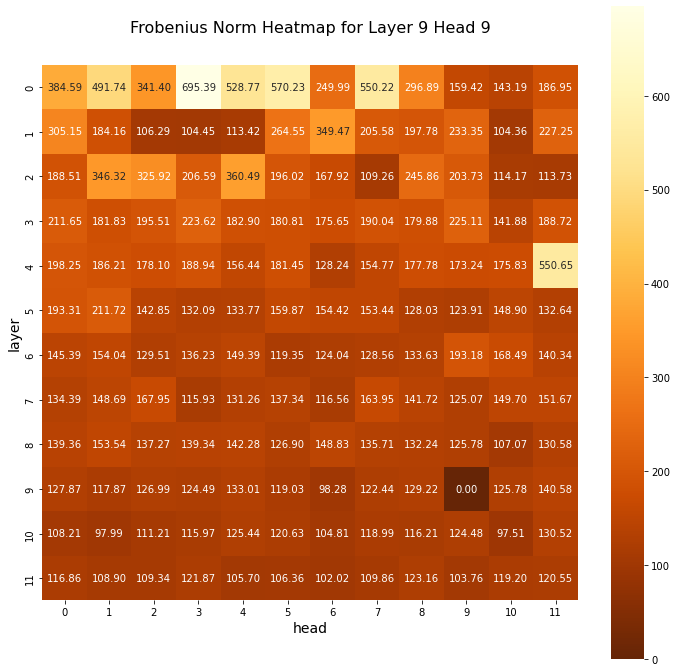

In [29]:
dist_reshape = np.reshape(head_res, (12, 12))
fig, axs = plt.subplots(ncols=1)
fig.set_size_inches(12, 12)
sns.heatmap(dist_reshape, annot=True, square=True, cmap = sns.color_palette("YlOrBr_r", as_cmap=True), fmt='.2f')
axs.set_xlabel('head', fontsize=14)
axs.set_ylabel('layer', fontsize=14)
axs.set_title('Frobenius Norm Heatmap for Layer 9 Head 9', fontsize=16, y=1.05)

### GPT query/key weights

In [39]:
query_weights = []
key_weights = []

for i in range(12):
    weights = model.h[i].attn.c_attn.weight
    query, key, value = torch.split(weights, 768, dim=1)
    query_weights.append(query)
    key_weights.append(key)

In [40]:
# get key/query weights for a particular layer and head of GPT
def get_weights(weights, layer, head): 
    layer_weights = weights[layer]

    start = head * 64
    end = start + 64
    
#     h_start = head * 64
#     h_end = h_start + 64
    
    head_weights = [i[start:end].detach().numpy() for i in layer_weights] # only use corresponding 64 columns of matrix
    return head_weights

# qw = get_weights(query_weights, 0, 0)
# kw = get_weights(key_weights, 0, 0)
# print(len(qw))
# print(len(qw[0]))

In [ ]:
qw_norms = []
kw_norms = []
cosine_sim = []


for layer in range(12):
    for head in range(12):
        qw = get_weights(query_weights, layer, head)
        kw = get_weights(key_weights, layer, head)
        
        qw_flat = np.asarray(qw).flatten()
        kw_flat = np.asarray(kw).flatten()
        
        # print(norm(qw_flat), norm(kw_flat))
        
        norm_q = norm(qw)
        norm_k = norm(kw)
        cosine = np.dot(qw_flat, kw_flat) / (norm_q * norm_k)
        
        qw_norms.append(norm_q)
        kw_norms.append(norm_k)
        cosine_sim.append(cosine)
        
        # print("Layer {}, Head {}: query norm = {:.4f}, key norm = {:.4f}, cosine sim = {:.4f}".format(layer, head, norm_q, norm_k, cosine))

In [ ]:
avg_cos = sum(cosine_sim) / len(cosine_sim)
min_cos = min(cosine_sim)
max_cos = max(cosine_sim)
print("Average cosine sim = {:.4f}".format(avg_cos))
print("Min cosine sim = {:.4f}".format(min_cos))
print("Max cosine sim = {:.4f}".format(max_cos))

In [ ]:
cosine_sim_reshape = np.reshape(cosine_sim, (12, 12))
fig, axs = plt.subplots(ncols=1)
fig.set_size_inches(12, 12)
sns.heatmap(cosine_sim_reshape, annot=True, square=True, cmap = sns.diverging_palette(220, 20, as_cmap=True), vmin=-0.7, vmax=0.9)
axs.set_xlabel('head', fontsize=14)
axs.set_ylabel('layer', fontsize=14)
axs.set_title('Cosine Similarity Between Query + Key Weights in GPT', fontsize=16, y=1.05)

In [ ]:
# get norm differences
norm_differences = [abs(qw_norms[i] - kw_norms[i]) for i in range(len(qw_norms))]

In [ ]:
stats.spearmanr(cosine_sim, norm_differences)[0]

In [ ]:
avg_diff = sum(norm_differences) / len(norm_differences)
min_diff = min(norm_differences)
max_diff = max(norm_differences)
print("Average norm difference = {:.4f}".format(avg_diff))
print("Min norm difference = {:.4f}".format(min_diff))
print("Max norm difference = {:.4f}".format(max_diff))

In [ ]:
norms_reshape = np.reshape(norm_differences, (12, 12))
fig, axs = plt.subplots(ncols=1)
fig.set_size_inches(12, 12)
sns.heatmap(norms_reshape, annot=True, square=True, cmap = sns.diverging_palette(20, 220, as_cmap=True), vmin=0, vmax=22)
axs.set_xlabel('head', fontsize=14)
axs.set_ylabel('layer', fontsize=14)
axs.set_title('Norm Difference Between Query + Key Weights in GPT', fontsize=16, y=1.05)

### BERT query/key weights

In [13]:
model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)

# check out parameters
# for name, param in model.named_parameters():                
#     print(name, param.size())

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
# get key + query weights
query_weights = []
key_weights = []

for i in range(12):
    query_weights.append(model.encoder.layer[i].attention.self.query.weight)
    key_weights.append(model.encoder.layer[i].attention.self.key.weight)
    
# print(len(query_weights))
# print(len(query_weights[0]))
# print(len(query_weights[0][:64]))
# print(query_weights[0][:64][:64])

In [ ]:
# get key/query weights for a particular layer and head of BERT
# def get_weights(weights, layer, head): 
#     layer_weights = weights[layer]
#     start = layer * 64
#     end = start + 64
#     head_weights = [i[:64].detach().numpy() for i in layer_weights[start:end]] # only use first 64 columns of matrix
#     return head_weights

qw = get_weights(query_weights, 0, 0)
kw = get_weights(key_weights, 0, 0)
print(len(qw))
print(len(qw[0]))
# print(qw)
# print(kw)

In [ ]:
bert_qw_norms = []
bert_kw_norms = []
bert_cosine_sim = []

for layer in range(12):
    for head in range(12):
        qw = get_weights(query_weights, layer, head)
        kw = get_weights(key_weights, layer, head)
        
        qw_flat = np.asarray(qw).flatten()
        kw_flat = np.asarray(kw).flatten()
        
        # print(norm(qw_flat), norm(kw_flat))
        
        norm_q = norm(qw)
        norm_k = norm(kw)
        cosine = np.dot(qw_flat, kw_flat) / (norm_q * norm_k)
        
        bert_qw_norms.append(norm_q)
        bert_kw_norms.append(norm_k)
        bert_cosine_sim.append(cosine)
        
        # print("Layer {}, Head {}: query norm = {:.4f}, key norm = {:.4f}, cosine sim = {:.4f}".format(layer, head, norm_q, norm_k, cosine))

In [ ]:
avg_cos = sum(bert_cosine_sim) / len(bert_cosine_sim)
min_cos = min(bert_cosine_sim)
max_cos = max(bert_cosine_sim)
print("Average cosine sim = {:.4f}".format(avg_cos))
print("Min cosine sim = {:.4f}".format(min_cos))
print("Max cosine sim = {:.4f}".format(max_cos))

In [ ]:
cosine_sim_reshape = np.reshape(bert_cosine_sim, (12, 12))
fig, axs = plt.subplots(ncols=1)
fig.set_size_inches(12, 12)
sns.heatmap(cosine_sim_reshape, annot=True, square=True, cmap = sns.diverging_palette(220, 20, as_cmap=True), vmin=-0.7, vmax=0.9)
axs.set_xlabel('head', fontsize=14)
axs.set_ylabel('layer', fontsize=14)
axs.set_title('Cosine Similarity Between Query + Key Weights in BERT', fontsize=16, y=1.05)

In [ ]:
# get norm differences
bert_norm_differences = [abs(bert_qw_norms[i] - bert_kw_norms[i]) for i in range(len(bert_qw_norms))]

In [ ]:
stats.spearmanr(bert_cosine_sim, bert_norm_differences)[0]

In [ ]:
avg_diff = sum(bert_norm_differences) / len(norm_differences)
min_diff = min(bert_norm_differences)
max_diff = max(bert_norm_differences)
print("Average norm difference = {:.4f}".format(avg_diff))
print("Min norm difference = {:.4f}".format(min_diff))
print("Max norm difference = {:.4f}".format(max_diff))

In [ ]:
norms_reshape = np.reshape(bert_norm_differences, (12, 12))
fig, axs = plt.subplots(ncols=1)
fig.set_size_inches(12, 12)
sns.heatmap(norms_reshape, annot=True, square=True, cmap = sns.diverging_palette(20, 220, as_cmap=True), vmin=0, vmax=22)
axs.set_xlabel('head', fontsize=14)
axs.set_ylabel('layer', fontsize=14)
axs.set_title('Norm Difference Between Query + Key Weights in BERT', fontsize=16, y=1.05)

#### translation

In [ ]:
# translate queries/keys

new_queries = []
new_keys = []
for layer in range(12):
    qw = get_weights(query_weights, layer)
    kw = get_weights(key_weights, layer)
    
    layer_q = []
    layer_k = []
    for head in range(12):
        residuals = get_residual(layer, head, all_embeddings)
        head_q = []
        head_k = []
        
        for i in range(5021):
            resid = residuals[i]
            pos = pos_embeddings[i]
            
            new_q = (resid - pos) @ qw
            new_k = (resid - pos) @ kw
            
            head_q.append(new_q)
            head_k.append(new_k)
        
        layer_q.append(head_q)
        layer_k.append(head_k)
    new_queries.append(layer_q)
    new_keys.append(layer_k)
        

In [ ]:
# testing output
print(len(new_queries))
print(len(new_queries[0]))
print(len(new_queries[0][0]))
print(len(new_queries[0][0][0]))
print(new_queries[0][0][0])

In [ ]:
print(sent_offset[:166])

In [ ]:
import numpy as np
from scipy.special import softmax

In [ ]:
# new attention too
new_attention = []
sent_offset_short = sent_offset[:166]

for layer in range(12):
    layer_a = []
    for head in range(12):
        queries = new_queries[layer][head]
        keys = new_keys[layer][head]
        head_a = []
        for i in range(len(sent_offset_short)):
            offset = sent_offset_short[i]
            sent_end = sent_offset_short[i + 1] if (i < len(sent_offset_short) - 1) else 5021
            sent_length = sent_end - offset

            for q in range(sent_length):
                qt = queries[q + offset] 
                sent_a = []
                for k in range(sent_length): 
                    kt = keys[k + offset]
                    dp = np.dot(qt, kt) / 8
                    sent_a.append(dp)
                sent_a = softmax(sent_a)
                head_a.append(sent_a)
        layer_a.append(head_a)
    new_attention.append(layer_a)

In [ ]:
# checking output
print(len(new_attention))
print(len(new_attention[0]))
print(len(new_attention[0][0]))
print(len(new_attention[0][0][0]))
print(new_attention[3][3][100])

### archive

In [ ]:
# adapted from bertviz: github.com/jessevig/bertviz
model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)
sentence_a = "This is a test"
sentence_b = "Hi my name is Catherine"
inputs = tokenizer.encode_plus(sentence_a, return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
output = model(input_ids, token_type_ids=token_type_ids)
attention = output[-1]
# sentence_b_start = token_type_ids[0].tolist().index(1)
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

In [ ]:
word_embeddings = output[0]
print(word_embeddings.shape)

In [ ]:
# check out parameters
for name, param in model.named_parameters():                
    print(name, param.size())

In [ ]:
print(model.encoder.layer[0].attention.self.query)

In [ ]:
print(model.encoder.layer[11].attention.self.query.bias)

In [ ]:
print(tokens)
print(len(tokens))
print(len(embeddings)) # num layers
print(len(embeddings[0][0])) # num tokens
print(len(embeddings[0][0][0])) # num tokens
print(embeddings[0][0][0][0]) # num tokens

In [ ]:
# check out output
print(sentence_a)
print(sentence_b)
print(tokens)
print(len(tokens))

In [ ]:
print(len(attention)) # corresponds to 12 layers of model
print(len(attention[0][0])) # 12 attention heads (e.g., different attention patterns/mechanisms)
print(attention[0][0][0].shape) # size of attention matrix (at each head)

In [ ]:
print(sum(attention[0][0][0][0])) # normalized, attention weights for each token must sum to 1

## Masking

In [ ]:
from transformers import pipeline
import random
model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)
unmasker = pipeline('fill-mask', model=model_version)

random.seed(10) # set seed

# encoded_input = tokenizer(text, return_tensors='pt')
# output = model(**encoded_input)

new_sentences = []
replaced = []

for sent in sentences:
    encoded = tokenizer(sent, return_tensors='pt')
    tokens = encoded['input_ids'][0]
    num_tokens = len(tokens) - 3 # don't include cls/sep
    mask_ind = random.randint(0, num_tokens) + 1
    old_token = ''.join(tokenizer.decode(tokens[mask_ind]).split(" ")) # save old token
    
    tokens[mask_ind] = 103 # replace randomly selected token with mask

    tokens = tokens[1:-1] # remove extra cls and sep
    new_sent = tokenizer.decode(tokens) # convert back to string
#     results = unmasker(new_sent)
#     final_res = results[0]['sequence'] # new sentence
#     new_token = results[0]['token_str'] # new token
    
#     if old_token == new_token:
#         final_res = results[1]['sequence'] # new sentence
#         new_token = results[1]['token_str'] # new token
#     replaced.append({"index": mask_ind, "old": old_token, "new": new_token}) # save to list
    replaced.append({"index": mask_ind, "old": old_token})
    
    # new_sentences.append(final_res)
    new_sentences.append(new_sent)
    # break
    
print(new_sentences[:10])
print(replaced[:10])

In [ ]:
tokenizer = BertTokenizer.from_pretrained(model_version)

for s1, s2 in zip(sentences, new_sentences):
    encoded1 = tokenizer(s1, return_tensors='pt')
    tokens1 = encoded1['input_ids'][0]
    encoded2 = tokenizer(s2, return_tensors='pt')
    tokens2 = encoded2['input_ids'][0]
    if len(tokens1) != len(tokens2):
        # print(tokens1)
        # print(tokens2)
        print(len(tokens1), s1)
        print(len(tokens2), s2)
        print("\n")

In [ ]:
tokenizer

## Getting Q, K vectors

Follow Jesse Vig's method of extracting query + key info

In [1]:
# import methods from bertviz
from bertviz import neuron_view
import numpy as np

# load sentences
sentences = np.load("sentences.npy")

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
from bertviz.transformers_neuron_view import BertModel, BertTokenizer, GPT2Model, GPT2Tokenizer
import random
import string

# BERT
# model_type = 'bert'
# model_version = 'bert-base-uncased'
# model = BertModel.from_pretrained(model_version, output_attentions=True)
# tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=True)

# GPT
model_type = 'gpt2'
model_version = 'gpt2'
model = GPT2Model.from_pretrained(model_version, output_attentions=True)
tokenizer = GPT2Tokenizer.from_pretrained(model_version, do_lower_case=True)

sentences_test = sentences[:10] # small sample to test out code with
num_heads = 12
num_layers = 12

# master dictionary for all values
attn_dict = {'left_text': [], 
             'right_text': [], 
             'positions': [],
             'normalized_positions': [],
             'sentences': [],
             'tokenized_sentences': [],
             'queries': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)], 
             'keys': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)],
             'attn': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)],
             'dot_prod': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)]}

for s in sentences:
    # call method from bertviz to get attention info
    s_dict = neuron_view.get_attention(model, model_type, tokenizer, s, include_queries_and_keys=True)['all']
    
    # append to master dictionary
    tokens = s_dict['left_text']
    attn_dict['left_text'].extend(tokens)
    attn_dict['right_text'].extend(s_dict['right_text'])
    
    for index in range(len(tokens)): # save position of token and tokenized sentences too
        attn_dict['positions'].append(index)
        attn_dict['normalized_positions'].append(index / (len(tokens) - 1))
        attn_dict['sentences'].append(s)
        attn_dict['tokenized_sentences'].append(' '.join(tokens))
        
    for i in range(num_heads): # updating cumulative q/k vectors + attn
        for j in range(num_layers):
            q = attn_dict['queries'][i][j]
            k = attn_dict['keys'][i][j]
            a = attn_dict['attn'][i][j]
            d = attn_dict['dot_prod'][i][j]
            
            if len(q) == 1: # on first round, need to empty list (random string was placeholder)
                q.clear()
            query = s_dict['queries'][i][j]
            q.extend(query)
            np_query = np.array(query)
            
            if len(k) == 1:
                k.clear()
            key = s_dict['keys'][i][j]
            k.extend(key)
            np_key = np.array(key)
            
            if len(a) == 1:
                a.clear()
            a.extend(s_dict['attn'][i][j])
            
            if len(d) == 1:
                d.clear()
            dp = np.dot(np_query, np_key.transpose())
            
            d.extend(dp)

In [13]:
# BERT
model_type = 'bert'
model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=True)

# GPT
# model_type = 'gpt2'
# model_version = 'gpt2'
# model = GPT2Model.from_pretrained(model_version, output_attentions=True)
# tokenizer = GPT2Tokenizer.from_pretrained(model_version, do_lower_case=True)

# master dictionary for all values
bert_attn_dict = {'left_text': [], 
             'right_text': [], 
             'positions': [],
             'normalized_positions': [],
             'sentences': [],
             'tokenized_sentences': [],
             'queries': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)], 
             'keys': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)],
             'attn': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)],
             'dot_prod': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)]}

for s in sentences:
    # call method from bertviz to get attention info
    s_dict = neuron_view.get_attention(model, model_type, tokenizer, s, include_queries_and_keys=True)['all']
    
    # append to master dictionary
    tokens = s_dict['left_text']
    bert_attn_dict['left_text'].extend(tokens)
    bert_attn_dict['right_text'].extend(s_dict['right_text'])
    
    for index in range(len(tokens)): # save position of token and tokenized sentences too
        bert_attn_dict['positions'].append(index)
        bert_attn_dict['normalized_positions'].append(index / (len(tokens) - 1))
        bert_attn_dict['sentences'].append(s)
        bert_attn_dict['tokenized_sentences'].append(' '.join(tokens))
        
    for i in range(num_heads): # updating cumulative q/k vectors + attn
        for j in range(num_layers):
            q = bert_attn_dict['queries'][i][j]
            k = bert_attn_dict['keys'][i][j]
            a = bert_attn_dict['attn'][i][j]
            d = bert_attn_dict['dot_prod'][i][j]
            
            if len(q) == 1: # on first round, need to empty list (random string was placeholder)
                q.clear()
            query = s_dict['queries'][i][j]
            q.extend(query)
            np_query = np.array(query)
            
            if len(k) == 1:
                k.clear()
            key = s_dict['keys'][i][j]
            k.extend(key)
            np_key = np.array(key)
            
            if len(a) == 1:
                a.clear()
            a.extend(s_dict['attn'][i][j])
            
            if len(d) == 1:
                d.clear()
            dp = np.dot(np_query, np_key.transpose())
            
            d.extend(dp)

In [13]:
attention = attn_dict["attn"]
positions = attn_dict["positions"]
sentences = attn_dict['tokenized_sentences']
tokens = attn_dict['left_text']

#### find interesting sentences

In [39]:
### checking sentences
def find_sentences(layer, head):
    sentence_list = []
    attn = attention[layer][head]
    
    for i in range(num_sent):
        offset = sent_offset[i]
        if i == num_sent - 1:
            sent_end = len(attn)
        else:
            sent_end = sent_offset[i + 1]
            
        sent_attn = attn[offset:sent_end]
        all_first = [a[0] for a in sent_attn]
        avg_first = sum(all_first) / len(all_first)
        
        sent = sentences[offset]
        if avg_first < 0.7:
            sentence_list.append(sent)
            
    # for i in range(len(attn)):
    #     a = attn[i]
    #     if a[0] < 0.5: # keep sentence if not that much attn to first token
    #         sent = sentences[i]
    #         if sent not in sentence_list:
    #             sentence_list.append(sent)
                
    return sentence_list


In [42]:
sentence_list = find_sentences(3, 0)
print(len(sentence_list))
for s in sentence_list:
    print(len(s), s)

5
211 The  notation  formula _ 8  indicates  the  set  of  all  infinite  sequences  over  the  alphabet  formula _ 1 ,  and  formula _ 10  indicates  the  set  formula _ 11  of  all  finite  or  infinite  sequences .
96 The  Mull s jo Ì Ī  Folk  High  School  is  a  folk  high  school  in  Mull s jo Ì Ī ,  Sweden .
406 The  province  is  mostly  mountainous  with  the  Mont i  de lla  Duchess a  and  the  Mont i  del  C icol ano  ranges  in  the  south  with  Monte  N uria  and  Monte  G iano ,  the  Mont i  Re at ini  range  with  Monte  Termin illo  ( 22 17  m )  in  the  north  in  part  of  the  Ab ru zz ese  Ap enn ines ,  and  Mont i  de lla  L aga  ( 24 58  m )  to  the  east  on  the  border  with  Ab ru zzo .
296 For  example ,  since  the  conson ant  phon eme  / n /  can  be  written  ,  ,  or  ( depending  on  the  spelling  of  the  particular  word ),  these  letters  are  not  simply  called  " no Ì Ĥ ";  instead ,  they  are  called  " d ental  no Ì Ĥ ",  " ce re bral 

In [ ]:
attention = attn_dict["attn"]
positions = attn_dict["positions"]
sentences = tok_sentences['tokenized_sentences']

In [38]:
for s in attn_dict['sentences']:
    if "infinite" in s:
        print(s)

The notation formula_8 indicates the set of all infinite sequences over the alphabet formula_1, and formula_10 indicates the set formula_11 of all finite or infinite sequences.
The notation formula_8 indicates the set of all infinite sequences over the alphabet formula_1, and formula_10 indicates the set formula_11 of all finite or infinite sequences.
The notation formula_8 indicates the set of all infinite sequences over the alphabet formula_1, and formula_10 indicates the set formula_11 of all finite or infinite sequences.
The notation formula_8 indicates the set of all infinite sequences over the alphabet formula_1, and formula_10 indicates the set formula_11 of all finite or infinite sequences.
The notation formula_8 indicates the set of all infinite sequences over the alphabet formula_1, and formula_10 indicates the set formula_11 of all finite or infinite sequences.
The notation formula_8 indicates the set of all infinite sequences over the alphabet formula_1, and formula_10 indi

### Aggregate attention matrices

In [27]:
max_pos = max(positions)
print(max_pos)

98


In [34]:
for layer in range(12):
    for head in range(12):
        gpt_attn_dict = [[[] for i in range(max_pos + 1)] for j in range(max_pos + 1)]
        lh_attn = attention[layer][head]
        for query in range(len(lh_attn)):
            tok_attn = lh_attn[query]
            q = positions[query]
            for k in range(len(tok_attn)):
                pair_attn = tok_attn[k]
                gpt_attn_dict[q][k].append(pair_attn)
        np.save("attention/layer{}_head{}.pkl".format(layer, head), gpt_attn_dict)

In [16]:
def avg_attns(test):
    for i in range(len(test)):
        for j in range(len(test[i])):
            cell = test[i][j]
            test[i][j] = sum(cell) / len(cell)
    return test

In [17]:
def normalize_attns(test):
    for i in range(len(test)):
        sum_row = sum(test[i])
        for j in range(len(test[i])):
            cell = test[i][j]
            test[i][j] = cell / sum_row
    return test

In [30]:
def get_agg_attn(layer, head):
    attn = np.load("attention/layer{}_head{}.pkl.npy".format(layer, head), allow_pickle=True)
    avg_attn = avg_attns(attn)
    norm_attn = normalize_attns(avg_attn)
    fin_attn = norm_attn.astype("float")
    np.save("attention_new/layer{}_head{}.npy".format(layer, head), fin_attn)
    return fin_attn

In [32]:
all_agg = []
for layer in range(12):
    for head in range(12):
        agg = np.load("gpt_attention/layer{}_head{}.npy".format(layer, head))
        all_agg.append(agg.flatten())

In [33]:
all_agg = np.asarray(all_agg)

In [36]:
test = get_agg_attn(3, 5)

Text(0.5, 1.05, 'Average Attention Weights in GPT (Layer 5 Head 1)')

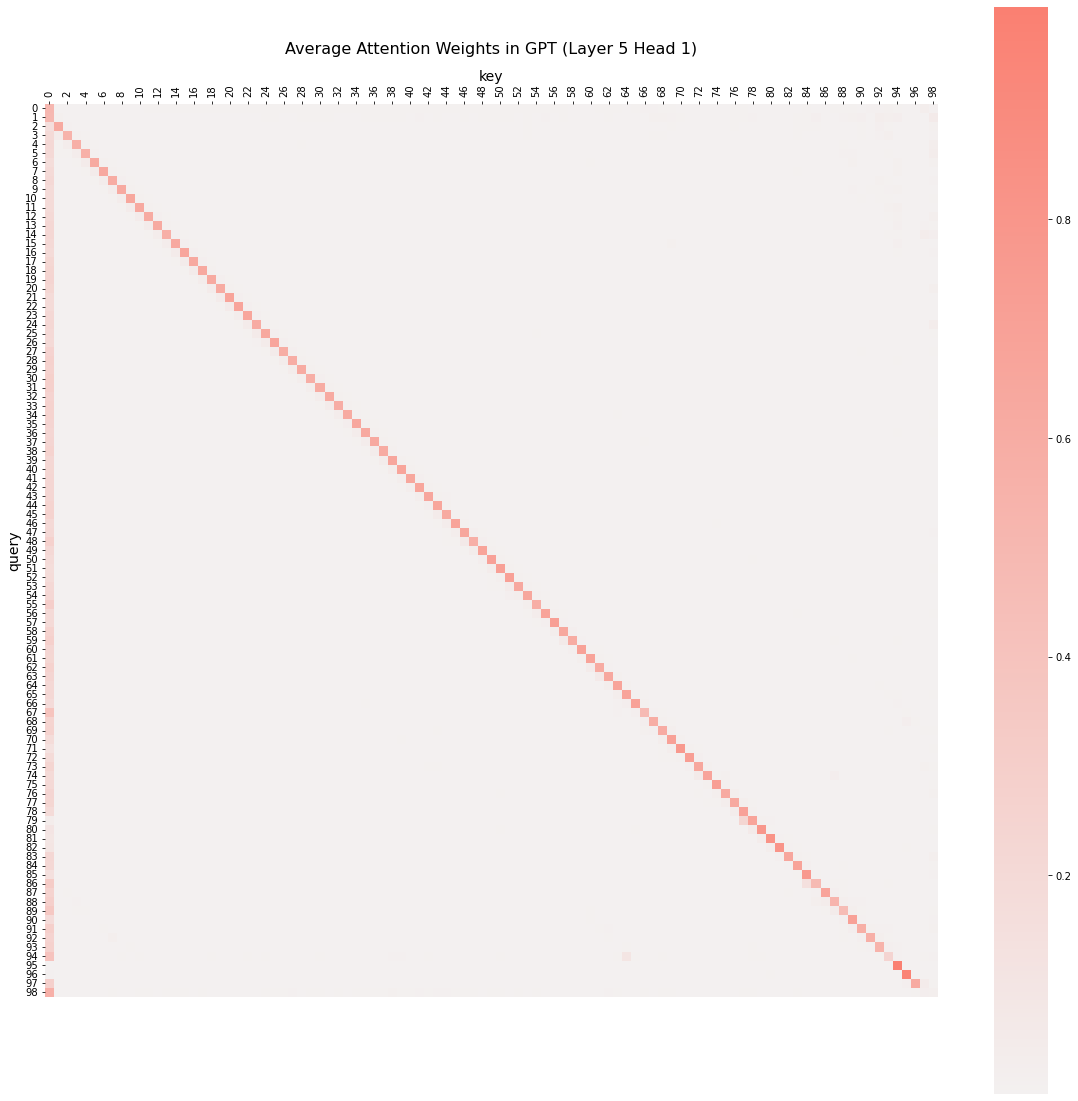

In [37]:
fig, axs = plt.subplots(ncols=1)
fig.set_size_inches(20, 20)
sns.heatmap(test, square=True, cmap=sns.color_palette("light:salmon", as_cmap=True))
axs.xaxis.tick_top()
axs.set_xlabel('key', fontsize=14)
axs.xaxis.set_label_position('top') 
plt.xticks(rotation = 90)
axs.set_ylabel('query', fontsize=14)
axs.set_title('Average Attention Weights in GPT (Layer 5 Head 1)', fontsize=16, y=1.05)

In [70]:
test12 = [[] for j in range(12)]
for i in range(len(test12)):
    empty = [test for i in range(12)]
    test12[i].append(empty)
    np_array = np.asarray(test12[i])
    test12[i] = torch.tensor(np_array)
    
# test12 = np.asarray(test12)
print(len(test12))
print(len(test12[0]))
print(test12[0].shape)
print(len(test12[0][0]))

12
1
torch.Size([1, 12, 111, 111])
12


In [71]:
html = head_view(test12, [str(i) for i in range(len(test))], layer=0, heads=[0], include_layers=[0], html_action='return') # generate html

with open('att.html', "w") as file: # save html to file
    file.write(html.data)

### Trying out attention plot generation

In [1]:
from bertviz.transformers_neuron_view import BertModel, BertTokenizer

## NEURON VIEW
# model_type = 'bert'
# model_version = 'bert-base-uncased'
# model = BertModel.from_pretrained(model_version, output_attentions=True)
# tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=True)

# sentence_a = "5000 yuan is a lot of money. 5.000 yuanes es mucho dinero."
sentence_a = "which famous jewellers makes the super bowl trophy? tiffany & co."

# generate html for attention view
# html = neuron_view.show(model, model_type, tokenizer, sentence_a, sentence_b=None, display_mode='dark', layer=0, head=0, html_action='return')

# with open('att.html', "w") as file: # save html to file
#     file.write(html.data)

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## HEAD VIEW
from transformers import BertTokenizer, BertModel, GPT2Model, GPT2Tokenizer
from bertviz import head_view

model_type = 'gpt2'
model_version = 'gpt2'
model = GPT2Model.from_pretrained(model_version, output_attentions=True)
tokenizer = GPT2Tokenizer.from_pretrained(model_version, do_lower_case=True)

inputs = tokenizer(sentence_a, return_tensors="pt")
outputs = model(**inputs)
attention = outputs.attentions

# model_version = 'bert-base-uncased'
# model = BertModel.from_pretrained(model_version, output_attentions=True)
# tokenizer = BertTokenizer.from_pretrained(model_version)

# inputs = tokenizer.encode_plus(sentence_a, return_tensors='pt')
input_ids = inputs['input_ids']
# token_type_ids = inputs['token_type_ids']
# attention = model(input_ids, token_type_ids=token_type_ids)[-1]
# sentence_b_start = token_type_ids[0].tolist().index(1)
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

html = head_view(attention, tokens, html_action='return') # generate html

with open('att2.html', "w") as file: # save html to file
    file.write(html.data)

In [42]:
print(len(attention))
print(len(attention[0]))
print(attention[0].shape)
print(len(attention[0][0]))
print(len(attention[0][0][0]))
print(len(attention[0][0][0][0]))

### checking output

In [ ]:
print(len(attn_dict['left_text']))
print(attn_dict['left_text'][:20])

print(len(attn_dict['positions']))
print(attn_dict['positions'][:20])

print(len(attn_dict['sentences']))
print(attn_dict['sentences'][:20])

print(len(attn_dict['tokenized_sentences']))
print(attn_dict['tokenized_sentences'][:20])

In [ ]:
# checking
print(attn_dict['tokenized_sentences'][0])
print(len(attn_dict['tokenized_sentences'][0].split()))

print("\n" + str(len(attn_dict['attn'])))
print(len(attn_dict['attn'][0]))
print(len(attn_dict['attn'][0][0]))
print(len(attn_dict['attn'][0][0][14]))

In [ ]:
print(attn_dict['left_text']) # see output for smaller sample

In [ ]:
print(attn_dict['queries'][0][0][0])

In [ ]:
# checking to make sure things look right
print(len(attn_dict['left_text'])) # num tokens
      
print(len(attn_dict['queries'])) # 12 layers
print(len(attn_dict['queries'][0])) # 12 heads
print(len(attn_dict['queries'][0][0])) # source sequence length (number of tokens)
print(len(attn_dict['queries'][0][0][0])) # vector size

In [ ]:
print(len(attn_dict['right_text'])) # num tokens
      
print(len(attn_dict['keys'])) # 12 layers
print(len(attn_dict['keys'][0])) # 12 heads
print(len(attn_dict['keys'][0][0])) # source sequence length (number of tokens)
print(len(attn_dict['keys'][0][0][0])) # vector size

### archive

In [ ]:
# this output does include query and key vectors
output = model(input_ids, token_type_ids=token_type_ids)

In [ ]:
"""
from bertviz documentation:
    get_attention method should return:
      Dictionary of attn representations with the structure:
      {
        'all': All attention (source = AB, target = AB)
        'aa': Sentence A self-attention (source = A, target = A) (if sentence_b is not None)
        'bb': Sentence B self-attention (source = B, target = B) (if sentence_b is not None)
        'ab': Sentence A -> Sentence B attention (source = A, target = B) (if sentence_b is not None)
        'ba': Sentence B -> Sentence A attention (source = B, target = A) (if sentence_b is not None)
      }
      where each value is a dictionary:
      {
        'left_text': list of source tokens, to be displayed on the left of the vis
        'right_text': list of target tokens, to be displayed on the right of the vis
        'attn': list of attention matrices, one for each layer. Each has shape [num_heads, source_seq_len, target_seq_len]
        'queries' (optional): list of query vector arrays, one for each layer. Each has shape (num_heads, source_seq_len, vector_size)
        'keys' (optional): list of key vector arrays, one for each layer. Each has shape (num_heads, target_seq_len, vector_size)
      }
"""
print(len(attn_dict))

## Attention Pattern Analysis

### installs

In [ ]:
!pip install nltk

In [ ]:
!pip install spacy

In [ ]:
!python -m spacy download en_core_web_sm

In [22]:
# downloads
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /n/home10/cyeh/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### get info from attn_dict

In [18]:
## gpt
attention = attn_dict["attn"]
print(len(attention[0][0]))
print(len(attention[0][0][0]))
positions = attn_dict["positions"]
print(len(positions))
tokens = attn_dict["left_text"]
print(len(tokens))
tok_sentences = attn_dict["tokenized_sentences"]

28679
14
28679
28679


In [30]:
## bert
attention = bert_attn_dict["attn"]
print(len(attention[0][0]))
print(len(attention[0][0][0]))
positions = bert_attn_dict["positions"]
print(len(positions))
tokens = bert_attn_dict["left_text"]
print(len(tokens))
tok_sentences = bert_attn_dict["tokenized_sentences"]

30070
13
30070
30070


In [32]:
# compute offset for each sentence in dataset
num_tokens = len(tok_sentences)

offset = 0
sent_offset = []
while offset < num_tokens:
    sent_offset.append(offset)
    cur_sent = tok_sentences[offset]
    sent_length = len(cur_sent.strip().split())
    if "   " in cur_sent:
        sent_length += 1
    offset += sent_length
    
num_sent = len(sent_offset)

print(len(sent_offset))
print(sent_offset[-1])

1000
30020


In [41]:
print(attn_dict["keys"][0][0][0])

[-1.5451565980911255, 1.9003686904907227, 0.45480257272720337, 0.2326134741306305, 0.5864970684051514, -0.1344853937625885, 0.5561538934707642, -0.19096575677394867, -1.4968875646591187, 0.0022542253136634827, -0.29308047890663147, 0.13175147771835327, 0.18392860889434814, -0.6756492257118225, -1.295971393585205, -0.5092719197273254, 0.49030566215515137, 0.28427398204803467, 2.163174629211426, -0.08766543865203857, -2.689213752746582, -0.9645175337791443, -0.4910575747489929, -0.8320187330245972, -0.06370820105075836, -0.727623462677002, -0.6636711955070496, -0.8632463812828064, -0.16455106437206268, -0.009535737335681915, 1.8188281059265137, -0.7318212985992432, -1.2319684028625488, 0.8476460576057434, 0.045709848403930664, 0.2907794713973999, 0.409832626581192, -0.408302366733551, 0.28515201807022095, 1.4030232429504395, -0.03132401406764984, 0.1713440716266632, -0.4670998752117157, 0.7288041114807129, -0.004904791712760925, -0.7504196763038635, -0.17379453778266907, -1.0903122425079

In [40]:
print(bert_attn_dict["keys"][0][0][0])

[1.279693603515625, 0.2204383760690689, 0.2408130168914795, -0.46212664246559143, -1.036665678024292, 0.6746782064437866, -0.1161804050207138, 0.5488025546073914, 0.2562941610813141, 0.8390980362892151, -0.13371682167053223, 0.7509193420410156, 0.5364178419113159, -0.3127976357936859, 0.7962762713432312, -0.7847825884819031, 0.2626582086086273, 0.04091387242078781, -2.0518627166748047, -0.5635623931884766, 0.41491079330444336, 0.016844715923070908, -0.35375869274139404, 0.4227973520755768, -0.7551289796829224, 0.5730921626091003, -0.21525034308433533, 1.773992896080017, 0.009853711351752281, 0.3883567452430725, -0.35956311225891113, -0.0848778784275055, -1.4009679555892944, -0.3241662383079529, -1.3165465593338013, 0.7856672406196594, -0.0036176973953843117, -0.8228550553321838, -0.5783448815345764, 0.32055559754371643, -1.0275752544403076, -0.36345401406288147, -0.4772486686706543, -1.0003379583358765, 0.5123111605644226, -1.1849173307418823, -0.5426142811775208, -0.3667975664138794, 

In [37]:
print(sent_offset[166])


5021


### semantics

In [378]:
import spacy
from spacy.tokens import Doc

In [379]:
nlp = spacy.load("en_core_web_sm")

In [157]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

In [158]:
stop_words = set(stopwords.words('english'))

In [421]:
# tag all tokens by part of speech
# tagged = nltk.pos_tag(tokens)

doc = Doc(nlp.vocab, tokens)
tagged = []
for token in nlp(doc):
    tagged.append(token.pos_)
        

In [422]:
num_pos = doc.count_by(spacy.attrs.POS)
for k,v in sorted(num_pos.items()):
    print(f'{k}. {nlp.vocab[k].text:{8}}: {v}')

84. ADJ     : 1064
85. ADP     : 945
86. ADV     : 630
87. AUX     : 141
89. CCONJ   : 88
90. DET     : 1253
91. INTJ    : 293
92. NOUN    : 7802
93. NUM     : 3583
94. PART    : 160
95. PRON    : 902
96. PROPN   : 5319
97. PUNCT   : 3317
98. SCONJ   : 82
99. SYM     : 70
100. VERB    : 2295
101. X       : 734
103. SPACE   : 1


In [427]:
# get all indices corresponding to POS tag type
def get_indices(tag):
    tag_indices = []
    for i in range(num_sent):
        offset = sent_offset[i]
        if i == num_sent - 1:
            sent_end = len(attn)
        else:
            sent_end = sent_offset[i + 1]

        sent_tag = []
        sent_tokens = tokens[offset:sent_end]

        # keep track of tokens with numbers/punct
        for t in range(len(sent_tokens)):
            tok = tokens[offset+t]
            tok_tag = tagged[offset+t]
            if tok not in ['[CLS]', '[SEP]'] and tok_tag == tag:
                sent_tag.append(t)
                # print(tok)

        tag_indices.append(sent_tag)
    return tag_indices
       
tag = "DET"
tag_indices = get_indices(tag)
num_tag = 0
for sent in tag_indices:
    num_tag += len(sent)
print(num_tag)

1253


In [428]:
### define some variables
tag_attn = [] 

for layer in range(12):
    for head in range(12):
        attn = attention[layer][head]
        
        # organize by head
        head_tag = []
        
        for i in range(num_sent):
            offset = sent_offset[i]
            if i == num_sent - 1:
                sent_end = len(attn)
            else:
                sent_end = sent_offset[i + 1]
            
            sent_attn = attn[offset:sent_end]
            sent_tag = tag_indices[i]
                    
            if len(sent_tag) == 0:
                # skip if no relevant tokens in sentence
                continue
            
            # now add attentions
            for a in sent_attn:
                for t in sent_tag:
                    head_tag.append(a[t])
        tag_attn.append(head_tag)


In [429]:
tag_avgs = []

for i in range(len(tag_attn)):
    head_tag = tag_attn[i]
    
    # find means
    tag_mean = sum(head_tag) / len(head_tag)
    
    tag_avgs.append(tag_mean)

In [417]:
bert_tag_avgs = []

for i in range(len(tag_attn)):
    head_tag = tag_attn[i]
    
    # find means
    tag_mean = sum(head_tag) / len(head_tag)
    
    bert_tag_avgs.append(tag_mean)

#### numbers/punct

In [98]:
### helper functions
def has_numbers(inputString):
    return any(char.isdigit() for char in inputString)

def has_punctuation(inputString):
    return any(char in string.punctuation and char != '#' for char in inputString)

In [152]:
# find indices of tokens with punctuation and numbers
num_indices = []
punct_indices = []

num_sent = len(sent_offset)

for i in range(num_sent):
    offset = sent_offset[i]
    if i == num_sent - 1:
        sent_end = len(attn)
    else:
        sent_end = sent_offset[i + 1]

    sent_num = []
    sent_punc = []

    sent_tokens = tokens[offset:sent_end]

    # keep track of tokens with numbers/punct
    for t in range(len(sent_tokens)):
        char = sent_tokens[t]
        if has_numbers(char):
            sent_num.append(t)
        # if has_punctuation(char):
        if '.' in char:
            sent_punc.append(t)
    
    num_indices.append(sent_num)
    punct_indices.append(sent_punc)
       
num_num = 0
for sent in num_indices:
    num_num += len(sent)
num_punc = 0
for sent in punct_indices:
    num_punc += len(sent)
print(num_num)
print(num_punc)

1016
1122


In [153]:
### define some variables
number_attn = [] # use has_numbers
punct_attn = [] # use has_punctuation

for layer in range(12):
    for head in range(12):
        attn = attention[layer][head]
        
        # organize by head
        head_num = []
        head_punct = []
        
        for i in range(num_sent):
            offset = sent_offset[i]
            if i == num_sent - 1:
                sent_end = len(attn)
            else:
                sent_end = sent_offset[i + 1]
            
            sent_attn = attn[offset:sent_end]
            sent_num = num_indices[i]
            sent_punc = punct_indices[i]
                    
            if len(sent_num) == 0 and len(sent_punc) == 0:
                # skip if no relevant tokens in sentence
                continue
            
            # now add attentions
            for a in sent_attn:
                for n in sent_num:
                    head_num.append(a[n])
                for p in sent_punc:
                    head_punct.append(a[p])
        number_attn.append(head_num)
        punct_attn.append(head_punct)


In [154]:
num_avgs = []
punct_avgs = []

for i in range(len(number_attn)):
    head_num = number_attn[i]
    head_punct = punct_attn[i]
    
    # find means
    num_mean = sum(head_num) / len(head_num)
    punct_mean = sum(head_punct) / len(head_punct)
    
    num_avgs.append(num_mean)
    punct_avgs.append(punct_mean)

### positional patterns

In [92]:
next_attn = []
prev_attn = []
self_attn = []
first_attn = []
last_attn = []

# keep track of different attention patterns

for layer in range(12):
    for head in range(12):
        attn = attention[layer][head]
        
        # organize by head
        # head_next = []
        # head_prev = []
        # head_self = []
        # head_first = []
        head_last = []
        for i in range(len(attn)):
            # pos = positions[i]
            token_att = attn[i]
            
            # first token
            # head_first.append(token_att[0])
            
            # last token
            head_last.append(token_att[-1])
            
            # self attention
            # head_self.append(token_att[pos])
            
            # attend to prev token
            # if pos > 0:
            #     head_prev.append(token_att[pos - 1])
                
            # attend to next token
            # if pos < len(token_att) - 1:
            #     head_next.append(token_att[pos + 1])
        
        # next_attn.append(head_next)
        # prev_attn.append(head_prev)
        # self_attn.append(head_self)
        # first_attn.append(head_first)
        last_attn.append(head_last)
        

In [93]:
next_avgs = []
prev_avgs = []
self_avgs = []
first_avgs = []
last_avgs = []

for i in range(len(last_attn)):
    # head_next = next_attn[i]
    # head_prev = prev_attn[i]
    # head_self = self_attn[i]
    # head_first = first_attn[i]
    head_last = last_attn[i]
    
    # find means
    # next_mean = sum(head_next) / len(head_next)
    # prev_mean = sum(head_prev) / len(head_prev)
    # self_mean = sum(head_self) / len(head_self)
    # first_mean = sum(head_first) / len(head_first)
    last_mean = sum(head_last) / len(head_last)
    
    # next_avgs.append(next_mean)
    # prev_avgs.append(prev_mean)
    # self_avgs.append(self_mean)
    # first_avgs.append(first_mean)
    last_avgs.append(last_mean)

### stats

In [21]:
def print_stats(means, pattern):
    avg_mean = sum(means) / len(means)
    min_mean = min(means)
    max_mean = max(means)
    print("Average attention to {} = {:.4f}".format(pattern, avg_mean))
    print("Min attention to {} = {:.4f}".format(pattern, min_mean))
    print("Max attention to {} = {:.4f}".format(pattern, max_mean))
    print("\n")

In [430]:
# print_stats(self_avgs, "self")
# print_stats(prev_avgs, "prev")
# print_stats(next_avgs, "next")
# print_stats(first_avgs, "first")
# print_stats(last_avgs, "last")

# print_stats(num_avgs, "numbers")
# print_stats(punct_avgs, "punctuation")

print_stats(tag_avgs, tag)

Average attention to DET = 0.0966
Min attention to DET = 0.0246
Max attention to DET = 0.1479




In [418]:
print_stats(bert_tag_avgs, tag)

Average attention to NOUN = 0.0155
Min attention to NOUN = 0.0018
Max attention to NOUN = 0.0375




### plots

Text(0.5, 1.05, 'Mean attention to verbs in GPT')

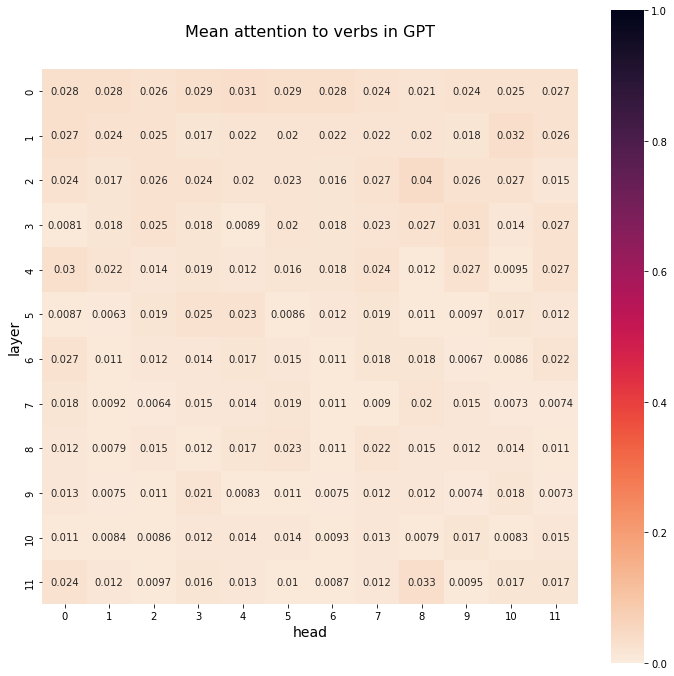

In [332]:
# plot heatmap for self attention
norms_reshape = np.reshape(tag_avgs, (12, 12))
fig, axs = plt.subplots(ncols=1)
fig.set_size_inches(12, 12)
sns.heatmap(norms_reshape, annot=True, square=True, cmap = sns.cm.rocket_r, vmin=0, vmax=1)
axs.set_xlabel('head', fontsize=14)
axs.set_ylabel('layer', fontsize=14)
axs.set_title('Mean attention to verbs in GPT', fontsize=16, y=1.05)

Text(0.5, 1.05, 'Mean attention to adjectives in BERT')

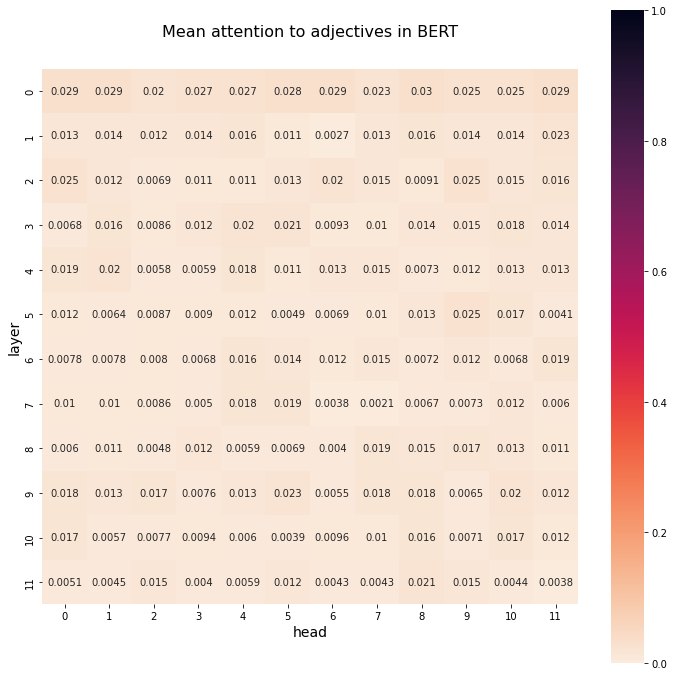

In [366]:
# plot heatmap for previous attention
norms_reshape = np.reshape(bert_tag_avgs, (12, 12))
fig, axs = plt.subplots(ncols=1)
fig.set_size_inches(12, 12)
sns.heatmap(norms_reshape, annot=True, square=True, cmap = sns.cm.rocket_r, vmin=0, vmax=1)
axs.set_xlabel('head', fontsize=14)
axs.set_ylabel('layer', fontsize=14)
axs.set_title('Mean attention to adjectives in BERT', fontsize=16, y=1.05)

## Context Embeddings

In [ ]:
# adapted from bertviz: github.com/jessevig/bertviz
model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)

all_embeddings = []

for sent in sentences:
    inputs = tokenizer.encode_plus(sent, return_tensors='pt')
    input_ids = inputs['input_ids']
    token_type_ids = inputs['token_type_ids']
    output = model(input_ids, token_type_ids=token_type_ids)
    embeddings = output[0]
    for e in embeddings[0]:
        all_embeddings.append(e)
    
    # break
    
print(len(all_embeddings))

In [ ]:
all_embeddings = all_embeddings[:5021] # only take first 5021 tokens
print(len(all_embeddings))

### archive

In [ ]:
!pip install flair

In [ ]:
from flair.data import Sentence
from flair.embeddings import BertEmbeddings
bert_embedding = BertEmbeddings()

embeddings = []

for sent in sentences:
    s = Sentence(sent)
    bert_embedding.embed(s)
    for token in s:
       embeddings.append(token.embedding)
    # break
    
print(len(embeddings))

## Residuals

In [ ]:
# adapted from bertviz: github.com/jessevig/bertviz
# model_version = 'bert-base-uncased'
# model = BertModel.from_pretrained(model_version, output_hidden_states=True)
# tokenizer = BertTokenizer.from_pretrained(model_version)

model_version = 'gpt2'
model = GPT2Model.from_pretrained(model_version, output_attentions=True)
tokenizer = GPT2Tokenizer.from_pretrained(model_version)

all_embeddings = [[] for i in range(12)]

for sent in sentences:
    inputs = tokenizer.encode_plus(sent, return_tensors='pt')
    input_ids = inputs['input_ids']
    token_type_ids = inputs['token_type_ids']
    output = model(input_ids, token_type_ids=token_type_ids)
    
    hidden_states = output[2][:-1]
    num_tokens = len(hidden_states[0][0])
    
    for layer in range(12):
        for token in range(num_tokens):
            all_embeddings[layer].append(hidden_states[layer][0][token])
    
    # break

In [43]:
# get residual for specific layer & head
def get_residual(layer, head, residuals):
    r_layer = residuals[layer]
    # each residual is 768 dimensions, so find the 64 that correspond to the selected attention head
    start_ind = head * 64 
    end_ind = start_ind + 64
    
    r_final = [i[start_ind:end_ind].detach().numpy() for i in r_layer]
    r_final = r_final[:5021] * 2 # only get first X keys + queries
    return r_final

resids = get_residual(0, 0, all_embeddings)
print(len(resids))
print(len(resids[0]))
print(norm(resids[0]))

10042
64
4.495472


## Positional Encodings

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# compute position encoding for some token
def getPositionEncoding(k, d=64, n=10000):
    P = np.zeros(d)
    for i in np.arange(int(d/2)):
        denominator = np.power(n, 2*i/d)
        # no noise
        P[2*i] = np.sin(k/denominator)
        P[2*i+1] = np.cos(k/denominator)
        # # or, add some random noise too
        # P[2*i] = np.sin(k/denominator) + np.random.normal(0,0.001)
        # P[2*i+1] = np.cos(k/denominator) + np.random.normal(0,0.001)
    return P

for i in range(4):
    P = getPositionEncoding(k=i)
    print(P)

In [ ]:
pos_embeddings = []
for ind in zip(attn_dict["positions"][:5021]):
    P = getPositionEncoding(k=ind)
    pos_embeddings.append(P)

In [ ]:
pos_embeddings += pos_embeddings
print(len(pos_embeddings))

In [ ]:
# run TSNE on position embeddings
def run_pos_tsne(df):
    # run TSNE
    # from: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
    time_start = time.time()
    # tsne = TSNE(n_components=3, verbose=0, perplexity=100, n_iter=300) # 3D
    tsne = TSNE(n_components=2, verbose=0, perplexity=100, n_iter=300) # 2D
    tsne_results = tsne.fit_transform(df)
    np.save("tsne/position_short.npy", tsne_results) # save tsne results too
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return tsne_results

tsne_results = run_pos_tsne(pos_embeddings)

In [ ]:
def run_pos_umap(df):
    # run umap
    time_start = time.time()
    umap = UMAP(n_components=2, init='random', random_state=0)
    umap_results = umap.fit_transform(df)
    np.save("umap/position_short.npy", umap_results) # save umap results too
    print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return umap_results

umap_results = run_pos_umap(pos_embeddings)

## Distances

### translate keys

In [ ]:
queries = attn_dict["queries"]
keys = attn_dict["keys"]

print(len(queries))
print(len(queries[0]))
print(len(queries[0][0]))
print(len(queries[0][0][0]))

In [ ]:
# get means
mean_queries = []
mean_keys = []
for layer in range(12):
    for head in range(12):
        q = queries[layer][head]
        k = keys[layer][head]
        num_tokens = len(q)
        mean_q = [0] * 64
        mean_k = [0] * 64
        for i in range(num_tokens):
            for j in range(64):
                q_token = q[i]
                k_token = k[i]
                mean_q[j] += q_token[j]
                mean_k[j] += k_token[j]
        
        mean_q = [i / num_tokens for i in mean_q]
        mean_k = [i / num_tokens for i in mean_k]
        mean_queries.append(mean_q)
        mean_keys.append(mean_k)
    #     break
    # break

In [ ]:
print(mean_queries[0])
print(mean_keys[0])

In [ ]:
# fix key means
new_mean_keys = []
for layer in range(12):
    for head in range(12):
        mean_k = [0] * 64
        k = keys[layer][head]
        m_k = mean_keys[12 * layer + head]
        q_k = mean_queries[12 * layer + head]
        num_tokens = len(k)
        for i in range(num_tokens):
            k_token = k[i]
            for j in range(64):
                orig_k = k_token[j]
                k_token[j] = orig_k - m_k[j] + q_k[j]  
                mean_k[j] += k_token[j]
        
        mean_k = [i / num_tokens for i in mean_k]
        new_mean_keys.append(mean_k)

In [ ]:
print(new_mean_keys[0])

#### Comparing embeddings

In [ ]:
## compute cosine similarity instead...
import numpy as np
from numpy.linalg import norm

similarities = []
for layer in range(12):
    for head in range(12):
        sim = []
        qs = queries[layer][head]
        ks = keys[layer][head]
        num_tokens = len(qs)
        for i in range(num_tokens):
            q = qs[i]
            k = ks[i]
            cosine = np.dot(q, k) / (norm(q) * norm(k))
            sim.append(cosine)
        similarities.append(sim)

In [ ]:
## mean similiarties
mean_similarities = []
for layer in range(12):
    for head in range(12):
        sim = similarities[layer * 12 + head]
        lh_mean = sum(sim) / len(sim)
        mean_similarities.append(lh_mean)

In [ ]:
import math
min_diff = min(mean_similarities)
min_i = mean_similarities.index(min_diff)
min_head = math.floor(min_i / 12)
min_layer = min_i % 12
max_diff = max(mean_similarities)
max_i = mean_similarities.index(max_diff)
max_head = math.floor(max_i / 12)
max_layer = max_i % 12

mean_sim = sum(mean_similarities) / len(mean_similarities)
print("mean: {}".format(mean_sim))
print("min: {} (head {}, layer {})".format(min_diff, min_head, min_layer))
print("max: {} (head {}, layer {})".format(max_diff, max_head, max_layer))

abs_means = [abs(i) for i in mean_similarities]

min_diff = min(abs_means)
min_i = abs_means.index(min_diff)
min_head = math.floor(min_i / 12)
min_layer = min_i % 12
max_diff = max(abs_means)
max_i = abs_means.index(max_diff)
max_head = math.floor(max_i / 12)
max_layer = max_i % 12

mean_sim = sum(mean_similarities) / len(mean_similarities)
print("mean: {}".format(mean_sim))
print("min: {} (head {}, layer {})".format(min_diff, min_head, min_layer))
print("max: {} (head {}, layer {})".format(max_diff, max_head, max_layer))

##### archive

In [ ]:
mean_differences = []
for layer in range(12):
    for head in range(12):
        q = queries[layer][head]
        k = keys[layer][head]
        num_tokens = len(k)
        diff = [0] * 64
        for i in range(num_tokens):
            k_token = k[i]
            q_token = q[i]
            for j in range(64):
                d = abs(k_token[j] - q_token[j])
                diff[j] += d
        diff = [i / num_tokens for i in diff]
        mean_differences.append(diff)

In [ ]:
print(mean_differences[0])

In [ ]:
# find mean diff for each layer/head combo
mean_overall = []
for m in mean_differences:
    mean_overall.append(sum(m) / len(m))
    
print(mean_overall)

In [ ]:
import math

In [ ]:
min_diff = min(mean_overall)
min_i = mean_overall.index(min_diff)
print(min_i)
min_head = math.floor(min_i / 12)
min_layer = min_i % 12
max_diff = max(mean_overall)
max_i = mean_overall.index(max_diff)
print(max_i)
max_head = math.floor(max_i / 12)
max_layer = max_i % 12
print("min: {} (head {}, layer {})".format(min_norm, min_head, min_layer))
print("max: {} (head {}, layer {})".format(max_norm, max_head, max_layer))

##### norms

In [ ]:
from numpy import linalg as LA

In [ ]:
## norms
norms = []
for m in mean_differences:
    n = LA.norm(m)
    norms.append(n)
    
print(norms)

In [ ]:
min_norm = min(norms)
min_i = norms.index(min_norm)
min_head = int(min_i / 12)
min_layer = min_i % 12
max_norm = max(norms)
max_i = norms.index(max_norm)
max_head = int(max_i / 12)
max_layer = max_i % 12
print("min: {} (head {}, layer {})".format(min_norm, min_head, min_layer))
print("max: {} (head {}, layer {})".format(max_norm, max_head, max_layer))

In [ ]:
mean_overall = [0] * 64
num_heads = len(mean_differences)
for layer in range(12):
    for head in range(12):
        m = mean_differences[12 * layer + head]
        for i in range(64):
            mean_overall[i] += m[i]

mean_overall = [i / num_heads for i in mean_overall]

In [ ]:
print(mean_overall)

### getting distances

#### archive

In [ ]:
# all distances
def get_distances(layer, head):
    distances = []

    for i in range(threshold):
        q = queries[layer][head][i]
        for j in range(i + 1, threshold): 
            k = keys[layer][head][j]
            d = distance.cosine(q, k)
            distances.append(d)
    return distances

In [ ]:
for layer in range(12):
    for head in range(12):
        distances = get_distances(layer, head)
        np.save("distances/layer{}_head{}.npy".format(layer, head), distances)
        print("layer {}, head {} done!".format(layer, head))

#### rest of code

In [ ]:
from scipy.spatial import distance
import pickle

In [ ]:
sentences = attn_dict["tokenized_sentences"]
num_tokens = len(sentences)
print(num_tokens)
print(sentences[0])

print(attn_dict["left_text"][5000:5021])
threshold = 5021

In [ ]:
# compute distance b/t key and query
# queries = attn_dict["queries"]
# keys = attn_dict["keys"]
def get_distances(layer, head):
    distances = []

    offset = 0
    while offset < threshold:
        s = sentences[offset] # get new sentence
        split = s.strip().split()
        l = len(split) # length of sentence
        if "   " in s:
            l += 1
        # if (split[0] != attn_dict['left_text'][offset]):
        #     print(offset)
        #     print(s)
        #     print(l)
        #     print(attn_dict['left_text'][offset:offset + l])
        for i in range(l): 
            dists = []
            q = queries[layer][head][offset + i] # iterate through all queries in sentence
            # for j in range(i + 1): # and keys 
            for j in range(l): # this is for bert
                k = keys[layer][head][offset + j]
                d = distance.cosine(q, k)
                dists.append(d)
            distances.append(dists)
        offset += l
    return distances

# distances = get_distances(0, 0)
# print(len(distances))

In [ ]:
all_dists = []
for layer in range(12):
    layer_dists = []
    for head in range(12):
        head_dists = get_distances(layer, head)
        layer_dists.append(head_dists)
        print("layer {}, head {} done".format(layer, head))
    all_dists.append(layer_dists)        

In [ ]:
with open('dists.p', 'wb') as file:
    pickle.dump(all_dists, file)

In [ ]:
print(len(all_dists))
print(len(all_dists[0]))
print(len(all_dists[0][0]))
print(len(all_dists[0][1]))

### correlation b/t distance and attention

In [ ]:
import pickle
# load distances back
distances = pickle.load( open( "dists.p", "rb" ) )

In [ ]:
# checking output
print(len(distances)) # layers
print(len(distances[11])) # heads
print(len(distances[11][0])) # all distances for layer 0, head 0
print(len(distances[11][0][0]))
print(distances[11][0][0])


In [ ]:
attention = attn_dict["dot_prod"] # switch to dot product
print(len(attention))
print(len(attention[0]))
print(len(attention[0][0]))
print(len(attention[0][0][0]))
print(attention[0][0][:13])

In [ ]:
from scipy import stats
import time

In [ ]:
correlation = []
for layer in range(12):
    for head in range(12):
        a = attention[layer][head][:5007]
        d = distances[layer][head][:5007]
        num_tokens = len(a)
        lh_cor = []
        offset = 0
        # start = time.time()
        while offset < num_tokens:
            sent_length = len(a[offset])
            if "   " in sentences[offset]:
                sent_length += 1
            s_cor = []
            for i in range(sent_length):
                a_matrix = a[offset + i]
                d_matrix = d[offset + i]
                c = stats.spearmanr(a_matrix, d_matrix)[0]
                s_cor.append(c)
            lh_cor.append(s_cor)
            offset += sent_length
        # print("time: {}".format(time.time() - start))
        correlation.append(lh_cor) 
        # print("layer {}, head {} done".format(layer, head))
        # break
    # break

In [ ]:
print(len(correlation))
print(len(correlation[0]))
print(correlation[0][0])

In [ ]:
## get mean per sentence
mean_cor = []
for layer in range(12):
    for head in range(12):
        lh_mean = []
        cor = correlation[layer * 12 + head]
        for sent in cor:
            sent_mean = sum(sent) / len(sent)
            lh_mean.append(sent_mean)
        mean_cor.append(lh_mean)

In [ ]:
print(len(mean_cor))
print(len(mean_cor[0]))
print(mean_cor[0])

In [ ]:
## get mean per head
mean_by_head = []
for layer in range(12):
    for head in range(12):
        lh_mean = mean_cor[layer * 12 + head]
        head_mean = sum(lh_mean) / len(lh_mean)
        mean_by_head.append(head_mean)

In [ ]:
## overall mean
total_sum = 0
min_mean = 10
min_layer = [0, 0]
max_mean = -10
max_layer = [0, 0]
for layer in range(12):
    for head in range(12):
        head_mean = mean_by_head[layer * 12 + head]
        print("layer {}, head {} mean: {}".format(layer, head, head_mean))
        total_sum += head_mean
        
        if head_mean < min_mean:
            min_mean = head_mean
            min_layer = [layer, head]
        if head_mean > max_mean:
            max_mean = head_mean
            max_layer = [layer, head]
        
total_mean = total_sum / 144
print("overall mean: {}".format(total_mean))
print("min mean: {} (layer {}, head {})".format(min_mean, min_layer[0], min_layer[1]))
print("min mean: {} (layer {}, head {})".format(max_mean, max_layer[0], max_layer[1]))

### distance vs. attention scatterplot

In [ ]:
import random

In [ ]:
# find mean distance and attention per att head
mean_distances = []
mean_attn = []
random_token = []

random.seed(10)

for layer in range(12):
    for head in range(12):
        a = attention[layer][head][:5007]
        d = distances[layer][head][:5007]
        num_tokens = len(a)
        lh_d = []
        lh_a = []
        offset = 0
        s = 0
        while offset < num_tokens:
            sent_length = len(a[offset])
            # if "  " in sentences[offset]:
            #     sent_length += 1
            # if len(random_token) < 166:
            #     t = random.randint(offset, offset + sent_length - 1)
            #     random_token.append(t)
            # else:
            #     t = random_token[s]
            # a_matrix = a[t]
            # d_matrix = d[t]
            # lh_d.append(sum(a_matrix) / len(a_matrix))
            # lh_a.append(sum(d_matrix) / len(d_matrix))
            s_d = []
            s_a = []
            for i in range(sent_length):
                a_matrix = a[offset + i]
                d_matrix = d[offset + i]
                s_a.append(sum(a_matrix) / len(a_matrix))
                s_d.append(sum(d_matrix) / len(d_matrix))
            lh_d.append(s_d)
            lh_a.append(s_a)
            offset += sent_length
            s += 1
        mean_distances.append(lh_d) 
        mean_attn.append(lh_a) 

In [ ]:
print(len(mean_distances))
print(len(mean_distances[0]))
print(len(mean_attn))
print(len(mean_attn[0]))

In [ ]:
sentence_mean_dists = []
sentence_mean_attn = []
for layer in range(12):
    for head in range(12):
        a = mean_attn[layer * 12 + head]
        d = mean_distances[layer * 12 + head]
        num_sents = len(a)
        lh_d = []
        lh_a = []
        for i in range(num_sents):
            s_a = sum(a[i]) / len(a[i])
            s_d = sum(d[i]) / len(d[i])
            lh_d.append(s_d)
            lh_a.append(s_a)
        sentence_mean_dists.append(lh_d) 
        sentence_mean_attn.append(lh_a) 

In [ ]:
print(len(sentence_mean_dists))
print(len(sentence_mean_dists[0]))
print(sentence_mean_dists[0])
print(len(sentence_mean_attn))
print(len(sentence_mean_attn[0]))
print(sentence_mean_attn[0])

In [ ]:
cor2 = []
for i in range(144):
    a = mean_attn[i]
    print(len(a))
    d = mean_distances[i]
    print(len(d))
    for i in a:
        if len(set(i)) == 1:
            print(a)
    cor2.append(stats.spearmanr(a, d)[0])
    
print(cor2)
print(sum(cor2) / len(cor2))

In [ ]:
overall_mean_d = [sum(i) / len(i) for i in sentence_mean_dists]
overall_mean_a = [sum(i) / len(i) for i in sentence_mean_attn]

print(overall_mean_d)
print(overall_mean_a)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# plt.scatter(overall_mean_d, overall_mean_a)
# plt.show()

fig, axs = plt.subplots(12, 12)

for layer in range(12):
    for head in range(12):
        ax = axs[layer, head]
        ax.scatter(distances[layer * 12 + head], sentence_mean_attn[layer * 12 + head], s=2, c='#6EAA8A')
        # ax.scatter(sentence_mean_dists[layer * 12 + head], sentence_mean_attn[layer * 12 + head], s=2, c='#6EAA8A')
        ax.set_title("L{} H{}".format(layer, head), fontsize=14)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        
fig.suptitle('Distance vs. Dot Product by Layer & Head', fontsize=16, y=1)
fig.set_size_inches(20, 18)
fig.tight_layout(pad=0.8)
fig.text(0.5, -0.01, 'Distance', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'Dot Product', va='center', rotation='vertical', fontsize=16)
plt.show()


### heatmaps

In [ ]:
# library
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
# compute offset for each sentence in dataset
tok_sentences = attn_dict["tokenized_sentences"]
num_sent = len(tok_sentences)

offset = 0
sent_offset = []
while offset < num_sent:
    sent_offset.append(offset)
    cur_sent = tok_sentences[offset]
    sent_length = len(cur_sent.strip().split())
    if "   " in cur_sent:
        sent_length += 1
    offset += sent_length
    
print(len(sent_offset))
print(sent_offset[-1])

In [ ]:
# find sentences w/ highest and lowest correlations
def find_high_and_low(layer, head, mean_cor, tok_sentences, sent_offset):
    means = mean_cor[layer * 12 + head]
    
    means_and_ind = [[means[i], i] for i in range(len(means))]
    means_and_ind = sorted(means_and_ind)
    
    k = 2
    lowest = means_and_ind[-2:]
    highest = means_and_ind[:2]
    
#     for l in lowest:
#         offset = sent_offset[l[1]]
#         sent = tok_sentences[offset]
#         print(sent)
        
#     for h in highest:
#         offset = sent_offset[h[1]]
#         sent = tok_sentences[offset]
#         print(sent)
    return lowest + highest
    
print(find_high_and_low(0, 1, mean_cor, tok_sentences, sent_offset))

In [ ]:
print(find_high_and_low(2, 7, mean_cor, tok_sentences, sent_offset))

In [ ]:
def make_heatmap(layer, head, distances, attention, mean_cor, sentences, sent_offset):
    d = distances[layer][head]
    a = attention[layer][head]
    
    res = find_high_and_low(layer, head, mean_cor, sentences, sent_offset)
    
    for r in res:
        i = r[1]
        c = r[0]
        offset = sent_offset[i]
        t = sentences[offset]
        
        sent_length = len(d[offset])
        dt = d[offset:offset+sent_length]
        at = a[offset:offset+sent_length]

        fig, axs = plt.subplots(ncols=2)
        fig.set_size_inches(16, 6.5)
        fig.suptitle('sentence {} (cor = {cor:.3f})'.format(i, cor=c), fontsize=16, y=1.1)

        sns.heatmap(dt, ax=axs[0])
        sns.heatmap(at, ax=axs[1], cmap = sns.cm.rocket_r)

        axs[0].set_xlabel('distance', fontsize=14)
        axs[0].set_xticks(range(sent_length), t.split(), rotation=90)
        axs[0].set_yticks(range(sent_length), t.split(), rotation=0)
        axs[0].xaxis.tick_top()

        axs[1].set_xlabel('dot product', fontsize=14)
        axs[1].set_xticks(range(sent_length), t.split(), rotation=90)
        axs[1].set_yticks(range(sent_length), t.split(), rotation=0)
        axs[1].xaxis.tick_top()

make_heatmap(0, 1, distances, attention, mean_cor, tok_sentences, sent_offset)

In [ ]:
make_heatmap(2, 7, distances, attention, mean_cor, tok_sentences, sent_offset)


In [ ]:
def print_norms(layer, head, distances, attention, mean_cor, sentences, sent_offset):
    # d = distances[layer][head]
    # a = attention[layer][head]
    q = query_norms[layer * 12 + head]
    k = key_norms[layer * 12 + head]
    
    res = find_high_and_low(layer, head, mean_cor, sentences, sent_offset)
    
    all_diffs = []
    for r in res:
        i = r[1]
        c = r[0]
        offset = sent_offset[i]
        t = sentences[offset]
        
        sent_length = len(d[offset])
        qt = q[offset:offset+sent_length]
        kt = k[offset:offset+sent_length]
        
        differences = []
        for a in range(len(qt)):
            q_diff = []
            for b in range(len(kt)):
                q_diff.append(qt[a] - kt[b])
            differences.append(q_diff)
        all_diffs.append(differences)
    return all_diffs

In [ ]:
differences = print_norms(2,7, distances, attention, mean_cor, sentences, sent_offset)
print(differences[0])

## norms check

In [ ]:
query_norms = []
key_norms = []

# queries = attn_dict['queries']
# keys = attn_dict['keys']
for layer in range(12):
    for head in range(12):
        norms_q = []
        norms_k = []
        for i in range(len(queries[layer][head])):
            q = queries[layer][head][i]
            k = keys[layer][head][i]
            norms_q.append(np.linalg.norm(q))
            norms_k.append(np.linalg.norm(k))
        query_norms.append(norms_q)
        key_norms.append(norms_k)
    
    

### medians

In [ ]:
import statistics

In [ ]:
qmedians = []
kmedians = []
for i in range(len(query_norms)):
    # per head
    q_i = query_norms[i]
    k_i = key_norms[i]
    
    q_median = statistics.median(q_i)
    k_median = statistics.median(k_i)
    qmedians.append(q_median)
    kmedians.append(k_median)

In [ ]:
print(qmedians)
print(kmedians)
overall_meanq = sum(qmedians) / len(qmedians)
overall_meank = sum(kmedians) / len(kmedians)
print("\nIn GPT, median query norm = {:2f}".format(overall_meanq))
print("\nIn GPT, median key norm = {:2f}".format(overall_meank))

### histograms

In [ ]:
qnorms_formatted = [item for sublist in query_norms for item in sublist]
knorms_formatted = [item for sublist in key_norms for item in sublist]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
w = 2 # width
min_norm = min(qnorms_formatted)
max_norm = max(qnorms_formatted)
range_norm = max_norm - min_norm
mean_norm = sum(qnorms_formatted) / len(qnorms_formatted)
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(0, 80), ylim=(0, 1.75e6))
plt.suptitle("query norms", fontsize=15)
plt.title("(mean: {:.2f}, min: {:.2f}, max: {:.2f}, range: {:.2f})".format(mean_norm, min_norm, max_norm, range_norm), fontsize=10)
plt.hist(qnorms_formatted, color="#5FB96C", bins=np.arange(min_norm, max_norm + w, w))
plt.show() 

In [ ]:
w = 2 # width
min_norm = min(knorms_formatted)
max_norm = max(knorms_formatted)
range_norm = max_norm - min_norm
mean_norm = sum(knorms_formatted) / len(knorms_formatted)
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlim=(0, 80), ylim=(0, 1.75e6))
plt.suptitle("key norms", fontsize=15)
plt.title("(mean: {:.2f}, min: {:.2f}, max: {:.2f}, range: {:.2f})".format(mean_norm, min_norm, max_norm, range_norm), fontsize=10)
plt.hist(knorms_formatted, color="#E3378F", bins=np.arange(min_norm, max_norm + w, w))
plt.show() 

### means overall

In [ ]:
qmeans = []
kmeans = []
for i in range(len(query_norms)):
    # per head
    q_i = query_norms[i]
    k_i = key_norms[i]
    
    q_mean = sum(q_i) / len(q_i)
    k_mean = sum(k_i) / len(k_i)
    qmeans.append(q_mean)
    kmeans.append(k_mean)

In [ ]:
print(qmeans)
print(kmeans)
overall_meanq = sum(qmeans) / len(qmeans)
overall_meank = sum(kmeans) / len(kmeans)
print("\nIn BERT, mean query norm = {:2f}".format(overall_meanq))
print("\nIn BERT, mean key norm = {:2f}".format(overall_meank))

In [ ]:
print(qmeans)
print(kmeans)
overall_meanq = sum(qmeans) / len(qmeans)
overall_meank = sum(kmeans) / len(kmeans)
print("\nIn GPT, mean query norm = {:2f}".format(overall_meanq))
print("\nIn GPT, mean key norm = {:2f}".format(overall_meank))

### first token - others

In [ ]:
# difference between first token and rest of words in sentence
query_diffs = []
key_diffs = []

for i in range(len(query_norms)):
    # per head
    q_i = query_norms[i]
    k_i = key_norms[i]
    
    qhead_diff = []
    khead_diff = []
    
    for s in range(len(sent_offset) - 1):
        offset = sent_offset[s]
        end_offset = sent_offset[s+1]
        q_sent = q_i[offset:end_offset]
        k_sent = k_i[offset:end_offset]
        
        for j in range(1, len(q_sent)):
            qdiff = q_sent[0] - q_sent[j]
            qhead_diff.append(qdiff)
            kdiff = k_sent[0] - k_sent[j]
            khead_diff.append(kdiff)
    query_diffs.append(qhead_diff)
    key_diffs.append(khead_diff)

In [ ]:
# mean differences
qmeans = []
kmeans = []
for d in range(len(query_diffs)):
    qhead = query_diffs[d]
    khead = key_diffs[d]
    qmean = sum(qhead) / len(qhead)
    kmean = sum(khead) / len(khead)
    qmeans.append(qmean)
    kmeans.append(kmean)

In [ ]:
print(qmeans)
print(kmeans)
overall_meanq = sum(qmeans) / len(qmeans)
overall_meank = sum(kmeans) / len(kmeans)
print("\nOn average in GPT, query 1st token norm - other token norm = {:2f}".format(overall_meanq))
print("\nOn average in GPT, key 1st token norm - other token norm = {:2f}".format(overall_meank))

In [ ]:
print(qmeans)
print(kmeans)
overall_meanq = sum(qmeans) / len(qmeans)
overall_meank = sum(kmeans) / len(kmeans)
print("\nOn average in BERT, query 1st token norm - other token norm = {:2f}".format(overall_meanq))
print("\nOn average in BERT, key 1st token norm - other token norm = {:2f}".format(overall_meank))

### differences

In [ ]:
# get differences in norms
differences = []
for i in range(len(query_norms)):
    q_i = query_norms[i]
    k_i = key_norms[i]
    
    head_diff = []
    for j in range(len(q_i)):
        diff = q_i[j] - k_i[j]
        head_diff.append(diff)
    differences.append(head_diff)
    

In [ ]:
# # mean differences
# means = []
# for d in differences:
#     mean = sum(d) / len(d)
#     means.append(mean)
    

In [ ]:
print(means)
overall_mean = sum(means) / len(means)
print("\nOn average in GPT, query norm - key norm = {:2f}".format(overall_mean))

In [ ]:
# mean differences
means2 = []
for d in differences:
    mean = sum(d) / len(d)
    means2.append(mean)

In [ ]:
print(means2)
overall_mean2 = sum(means2) / len(means2)
print("\nOn average in BERT, query norm - key norm = {:2f}".format(overall_mean2))

## Playing with TSNE / UMAP

Generating plots from query + key vectors

### installs

In [ ]:
!pip install -U scikit-learn

In [ ]:
!pip install plotly

In [ ]:
!pip install seaborn

In [ ]:
!pip install umap-learn

### start code

In [16]:
# import
from sklearn.manifold import TSNE
from umap import UMAP
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# ensure plots show up in jupyter
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "iframe"

In [ ]:
import pickle
# load attn_dict back
attn_dict = pickle.load( open( "attn_dict.p", "rb" ) )

In [18]:
# produce corresponding key matrix from query matrix (e.g., for attention)
def k_matrix(q_matrix):
    # assumes for specific layer + head (e.g., queries[0][0])
    num_tokens = len(q_matrix)
    k_matrix = []
    i = 0
    while i < num_tokens:
        q = q_matrix[i]
        sent_length = len(q)
        for k_i in range(sent_length):
            k = []
            for q_i in range(sent_length):
                k.append(q_matrix[q_i + i][k_i])
            k_matrix.append(k)
        i += sent_length
    
    return k_matrix
    
# res = k_matrix(attn_dict["attn"][0][0][:13])
# print(attn_dict["attn"][0][0][:13])
# print(res)
# print(len(res))
# print(len(res[0]))

In [32]:
#layer = 0
#head = 0

def fix_sentences(sentences, positions, types):
    # format sentences to be displayed in html plot
    new_sentences = []
    for sent, pos, t in zip(sentences, positions, types):
        s_arr = sent.split()
        s = ""
        for i in range(len(s_arr)):
            if i % 10 == 0 and i not in [0, len(s_arr) - 1]:
                s += "<br>" # add new line every 10 tokens
                
            if i == pos: # italicize  + color current token
                color = "#B6E1B9"
                if t == "key":
                    color = "#F6BA98"
                s += "<b style='color:" + color + "'>" + s_arr[i] + "</b>"
            else:
                s += s_arr[i]
                
            if s != len(s_arr) - 1:
                s += " " # add space back between each token
        new_sentences.append(s)
    
    return new_sentences

def make_df(layer, head):
# convert data into pandas dataframe
    df = pd.DataFrame()
    df['token'] = attn_dict['left_text'] + attn_dict['right_text'] # store tokens
    df['token'] = df['token'].str.lower() # convert to lowercase
    num_tokens = len(attn_dict['left_text'])
    
    df['type'] = ['query'] * num_tokens + ['key'] * num_tokens # store token type
    df['pos_int'] = attn_dict['positions'] * 2 # positions
    df['position'] = attn_dict['normalized_positions'] * 2
    
    # sentence itself
    # df['sentence'] = fix_sentences(attn_dict['tokenized_sentences'], attn_dict['positions'], df['type'][:num_tokens]) + fix_sentences(attn_dict['tokenized_sentences'], attn_dict['positions'], df['type'][num_tokens:])
    df['sentence'] = [s.lower() for s in attn_dict['tokenized_sentences']] * 2
    
    # save attn info
    attn = attn_dict['attn'][layer][head]
    df['attn'] = attn + k_matrix(attn)
    #df['max_ind'] = [a.index(max(a)) for a in df['attn']]
    dp = attn_dict['dot_prod'][layer][head]
    df['dot_prod'] = dp + k_matrix(dp)
    
    # extract q/k vectors
    queries = attn_dict['queries']
    keys = attn_dict['keys']
    # queries = new_queries
    # keys = new_keys
    vec_size = len(queries[layer][head][0])

    # norms
    norms_q = []
    norms_k = []
    for i in range(len(queries[layer][head])):
        q = queries[layer][head][i]
        k = keys[layer][head][i]
        norms_q.append(np.linalg.norm(q))
        norms_k.append(np.linalg.norm(k))
    df["norm"] = norms_q + norms_k
    
    # df = pd.concat([df.iloc[:5021], df.iloc[30070:30070+5021]]) # only get first X keys + queries

    for i in range(vec_size): # store q/k vector values
        qs = [queries[layer][head][j][i] for j in range(num_tokens)]
        ks = [keys[layer][head][j][i] for j in range(num_tokens)]
        df["f" + str(i)] = qs + ks # add to dataframe
        
    # comment out line below if want all 60k data points
    df = pd.concat([df.iloc[:5007], df.iloc[28679:28679+5007]]) # gpt
    # df = pd.concat([df.iloc[:5021], df.iloc[30070:30070+5021]]) # bert
    # df = pd.concat([df.iloc[:5024], df.iloc[30085:30085+5024]]) # only get first X keys + queries
    # print(len(df))
    # df_lab = df.iloc[:, :8].copy() # get label cols only
    df.to_csv('layer{}_head{}.csv'.format(layer, head), index=False)
    # df_lab.to_csv('layer' + str(layer) + '/labels' + str(head) + '.tsv', sep="\t", index=False) # save labels to file
    
    return df

# testing
df = make_df(1, 2)
df.tail(10)

,token,type,pos_int,position,sentence,attn,dot_prod,norm,f0,f1,...,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63
33676,degree,key,6,0.400000,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1243270859122...","[-13.046032464386531, -18.92044913470422, -15....",4.251553,-0.165490,-0.455163,...,0.028001,-0.104282,0.945354,1.356283,-0.630933,0.066298,-0.049647,-0.961263,0.051021,0.192271
33677,from,key,7,0.466667,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21140174...","[-9.542935143126776, -11.027076613057744, -9.2...",4.351697,-0.070377,-0.186032,...,-0.170136,-0.173247,0.799077,1.296030,-0.558702,0.111981,-0.055555,-0.957584,0.231267,0.217181
33678,the,key,8,0.533333,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.184...","[-8.333902244105557, -10.565040761095037, -8.5...",4.386984,-0.070236,-0.077174,...,-0.204657,-0.889120,1.125555,1.468779,-0.615570,0.444403,-0.198410,-0.688448,0.377872,0.207750
33679,university,key,9,0.600000,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-11.55961318626591, -17.469658300678933, -14....",4.025716,0.277272,-0.527442,...,-0.376452,0.061742,0.701747,1.613002,-0.626181,0.169012,-0.079601,-0.951412,-0.002236,0.427343
33680,of,key,10,0.666667,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-7.360348619543907, -8.452249927709813, -7.01...",4.330401,-0.123005,-0.131495,...,0.009633,-0.267608,0.925500,1.464080,-0.753767,0.230120,-0.294182,-0.773124,0.115910,0.165729
33681,western,key,11,0.733333,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-11.464520825201133, -17.9277108617094, -15.2...",4.001034,0.165821,-0.384317,...,-0.382434,-0.054419,0.783440,1.707273,-0.544521,-0.166136,-0.162974,-0.666544,-0.319569,0.215440
33682,australia,key,12,0.800000,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-8.3018655622655, -11.14412708360897, -9.2368...",3.814458,-0.466861,-0.324063,...,-0.251508,-0.372671,0.765145,1.444870,-0.139269,-0.091538,-0.055186,-0.848108,0.338557,0.503233
33683,in,key,13,0.866667,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-6.073180669600748, -6.427793515842042, -5.40...",4.122116,-0.114905,-0.339134,...,-0.243867,-0.301714,0.702755,1.554849,-0.609225,0.311219,-0.229851,-0.780414,0.296170,0.371514
33684,1964,key,14,0.933333,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-8.256445914490332, -14.140688783935488, -12....",3.593744,-0.298268,-0.187092,...,-0.426633,-0.132420,0.587476,1.576056,-0.139140,0.010959,-0.392681,-0.722634,0.324757,0.282162
33685,.,key,15,1.000000,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.661043644538163, -5.052468780170742, -4.15...",3.912532,-0.107773,-0.182402,...,0.032009,-0.137743,0.380034,1.299862,-0.611678,0.111740,-0.046442,-1.232940,0.076320,-0.036805


### translating key vectors
Translate keys to have same centroid as queries for easier(?) comparison

In [20]:
def find_q_means(df):
    # find mean of each feature in query embeddings
    df_queries = df.loc[df['type'] == 'query']
    df_queries = df_queries.iloc[:, 8:].copy()
    # df_queries.head()
    query_means = df_queries.mean(axis=0)
    return query_means

# query_means = find_q_means(df)
# query_means

In [21]:
def find_q_means_selective(df):
    # find mean of each feature in query embeddings if norm is around mean
    # mean_norm = df["norm"].median()
    # print(mean_norm)
    mean_norm = 9.84 # GPT query norm
    lower_bound = mean_norm - 1
    upper_bound = mean_norm + 1
    df_queries = df.loc[(df['type'] == 'query') & (df['norm'] > lower_bound) & (df['norm'] < upper_bound)]
    df_queries = df_queries.iloc[:, 8:].copy()
    # df_queries.head()
    query_means = df_queries.mean(axis=0)
    return query_means
    
# find_q_means_selective(df)

In [22]:
def find_k_means(df):
    # find mean of each feature in key embeddings
    df_keys = df.loc[df['type'] == 'key']
    df_keys = df_keys.iloc[:, 8:].copy()
    # df_keys.head()
    key_means = df_keys.mean(axis=0)
    # key_means
    return df_keys, key_means

# df_keys, key_means = find_k_means(df)
# key_means

In [23]:
def translate_keys(df, df_keys, query_means, key_means):
# translate key vectors accordingly
    # new_keys = pd.DataFrame()
    for i in range(64):
        col = "f" + str(i)
        new_key = df_keys[col] - key_means[col] + query_means[col]
        df.loc[df['type'] == 'key', col] = new_key

    # print(new_keys.head())
    new_means = df[df.type == 'key'].mean(axis=0)
    # print(new_means)
    # df.tail()
    return df

# df = translate_keys(df, df_keys, query_means, key_means)

In [24]:
def translate_queries_and_keys(df):
    df_queries = df.loc[df['type'] == 'query']
    df_queries = df_queries.iloc[:, 8:].copy()
    df_keys = df.loc[df['type'] == 'key']
    df_keys = df_keys.iloc[:, 8:].copy()
    for i in range(64):
        col = "f" + str(i)
        new_key = df_keys[col]*10
        new_query = df_queries[col]/10
        df.loc[df['type'] == 'key', col] = new_key
        df.loc[df['type'] == 'query', col] = new_query
    return df

df = translate_queries_and_keys(df)

In [33]:
# whole translation loop
def translate_loop(df): 
    query_means = find_q_means(df)
    # query_means = find_q_means_selective(df)
    df_keys, key_means = find_k_means(df)
    df = translate_keys(df, df_keys, query_means, key_means)
    return df

df = translate_loop(df)
df.tail()

<ipython-input-23-e5a17867bf1e>:10: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,token,type,pos_int,position,sentence,attn,dot_prod,norm,f0,f1,...,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63
33681,western,key,11,0.733333,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-11.464520825201133, -17.9277108617094, -15.2...",4.001034,0.406407,-0.824863,...,-0.304570,-0.685819,-0.349346,-2.975479,3.178447,0.295821,-0.071158,1.000928,-0.156295,-0.136290
33682,australia,key,12,0.800000,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-8.3018655622655, -11.14412708360897, -9.2368...",3.814458,-0.226276,-0.764609,...,-0.173644,-1.004072,-0.367642,-3.237883,3.583699,0.370419,0.036630,0.819364,0.501831,0.151504
33683,in,key,13,0.866667,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-6.073180669600748, -6.427793515842042, -5.40...",4.122116,0.125681,-0.779680,...,-0.166003,-0.933115,-0.430032,-3.127903,3.113744,0.773176,-0.138035,0.887057,0.459444,0.019785
33684,1964,key,14,0.933333,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-8.256445914490332, -14.140688783935488, -12....",3.593744,-0.057683,-0.627638,...,-0.348769,-0.763821,-0.545311,-3.106696,3.583829,0.472915,-0.300865,0.944837,0.488032,-0.069568
33685,.,key,15,1.000000,he earned a bachelor of laws degree fro...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.661043644538163, -5.052468780170742, -4.15...",3.912532,0.132812,-0.622948,...,0.109873,-0.769143,-0.752753,-3.382890,3.111290,0.573697,0.045374,0.434532,0.239595,-0.388535


### subtracting position

In [ ]:
def subtract_pos(df, layer, head, all_embeddings):
    resids = get_residual(layer, head, all_embeddings)
    for p in range(len(pos_embeddings)):
        for i in range(64):
            # col = "f" + str(i)
            df.iloc[p, 8 + i] -= resids[p][i] - pos_embeddings[p][i]
    
    return df
   
# df = subtract_pos(df, 3, 3, all_embeddings)
# df.tail()

### plot generation

#### pca

In [ ]:
# imports
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
import seaborn as sns

In [ ]:
# run PCA
def run_pca(df, dim, layer, head):
     # prepare data for feature plot
    df_sub = df.iloc[:, 8:].copy()
    df_subset = df_sub.values # only get feature cols
    
    # run PCA
    time_start = time.time()
    
    if dim == 3:
        pca = PCA(n_components=3) # 3D
    else:
        pca = PCA(n_components=2) # 2D
    pca_results = pca.fit_transform(df_subset)
    np.save("pca" + str(dim) + "d/layer" + str(layer) + "_head" + str(head) + ".npy", pca_results) # save results too
    print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
#     type_list = list(df['type'])
#     # Create dataframe
#     if dim == 2: # 2D
#         pca_df = pd.DataFrame(
#             data=pca_results, 
#             columns=['PC1', 'PC2'])
#     else:
#         pca_df = pd.DataFrame( # 3D
#             data=pca_results,  
#             columns=['PC1', 'PC2', 'PC3'])

#     pca_df['type'] = type_list
#     return pca_df

In [ ]:
def plot_pca(df, layer, head):
    sns.set()
    colors = ['#5FB96C', '#E3378F']
    # Set your custom color palette
    sns.set_palette(sns.color_palette(colors))

    sns.lmplot(
        x='PC1', 
        y='PC2', 
        data=df, 
        hue='type', 
        fit_reg=False, 
        legend=True
        )

    plt.title('Layer {} Head {}'.format(layer, head))
    plt.savefig('pca/layer{}_head{}.png'.format(layer, head))
    # plt.show()

In [ ]:
def pca_loop(layer, head):
    df2 = make_df(layer, head)
    df2 = translate_loop(df2)
    # run_pca(df2, 2, layer, head) # 2d
    run_pca(df2, 3, layer, head) # 3d
    # plot_pca(pca_df, layer, head)
    
    

In [ ]:
for layer in range(12):
    for head in range(12):
        pca_loop(layer, head)
        print("Layer {}, head {} done!".format(layer, head))
              

In [ ]:
## make grid
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image


def img_reshape(img):
    img = Image.open('pca/'+img).convert('RGB')
    img = img.resize((400,300))
    img = np.asarray(img)
    return img

images = os.listdir('pca/')
img_arr = []

for layer in range(12):
    for head in range(12):
        img_arr.append(img_reshape("layer{}_head{}.png".format(layer, head)))
    
rows = 12
cols = 12
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(24,20))

for i in range(rows):
    for j in range(cols):        
        if img_count < len(images):
            axes[i, j].axis('off')
            axes[i, j].imshow(img_arr[img_count])
            img_count+=1
            
plt.tight_layout()
fig.suptitle('PCA results by attention head', fontsize=16, y=1.01)
fig.text(0.5, -0.01, 'Head', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'Layer', va='center', rotation='vertical', fontsize=16)
plt.show()

#### tsne + umap

##### projection of projections

###### dists

In [35]:
# new_features = []
layers = []
heads = []
for layer in range(12):
    for head in range(12):
        # dists = all_dists[layer][head]
        # head_d = []
        # for d in dists:
        #     head_d.extend(d)
        # dists = np.asarray(head_d)
        # new_features.append(dists)
        layers.append(layer)
        heads.append(head)
        
df = pd.DataFrame()
df["layers"] = layers
df["heads"] = heads

###### coords from file

In [ ]:
import os

In [ ]:
queries = attn_dict["queries"]
keys = attn_dict["keys"]

In [ ]:
new_features = []
layers = []
heads = []
for layer in range(12):
    for head in range(12):
        q = queries[layer][head][:5007]
        k = queries[layer][head][:5007]
        q = np.asarray(q).flatten()
        k = np.asarray(k).flatten()
        combined = np.concatenate((q, k), axis=None)
        new_features.append(combined)
        layers.append(layer)
        heads.append(head)
        
df = pd.DataFrame()
df["layers"] = layers
df["heads"] = heads

In [36]:
# gpt
patterns = ["other", "self", "other", "self", "self", "self", "other", "other", "other", "other", "other", "other",
            "other", "other", "other", "other", "other", "other", "other", "other", "other", "other", "other", "self",
            "other", "other", "previous", "other", "other", "other", "other", "other", "other", "other", "other", "other",
            "self", "other", "other", "previous", "self", "other", "previous", "previous", "other", "other", "other", "other",
            "other", "other", "other", "other", "self", "other", "other", "self", "self", "other", "other", "previous",
            "ind-next", "ind-next", "other", "other", "other", "ind-next", "previous", "other", "ind-next", "other", "other", "self",
            "other", "other", "other", "other", "other", "other", "self", "other", "previous", "ind-next", "ind-next", "other",
            "previous", "other", "ind-next", "other", "ind-prev", "other", "other", "other", "other", "other", "ind-next", "ind-next",
            "other", "ind-next", "other", "other", "other", "other", "ind-next", "other", "other", "other", "other", "other",
            "other", "ind-next", "other", "other", "other", "self", "ind-next", "other", "other", "ind-next", "other", "other",
            "ind-next", "ind-next", "other", "other", "other", "other", "ind-next", "ind-next", "other", "other", "other", "ind-next",
            "other", "other", "other", "other", "other", "other", "other", "other", "self", "ind-next", "ind-next", "other"]
df['patterns'] = patterns

In [5]:
# bert
patterns = ["other", "other", "previous", "previous", "other", "other", "other", "other", "other", "other", "next", "other",
            "other", "next", "other", "other", "previous", "other", "other", "other", "other", "other", "other", "self",
            "next", "other", "other", "other", "other", "other", "self", "other", "other", "next", "other", "other",
            "self", "other", "other", "next", "other", "previous", "other", "other", "other", "next", "other", "previous",
            "other", "other", "other", "self", "other", "other", "other", "other", "other", "other", "other", "next",
            "other", "other", "other", "other", "other", "self", "other", "other", "other", "next", "previous", "other",
            "self", "other", "other", "other", "other", "other", "next", "other", "other", "other", "other", "previous",
            "ind-next", "other", "next", "other", "previous", "other", "other", "other", "other", "other", "other", "other",
            "other", "other", "ind-next", "self", "other", "other", "other", "other", "other", "other", "other", "other",
            "self", "other", "other", "other", "other", "other", "self", "self", "self", "ind-prev", "other", "other",
            "other", "self", "other", "other", "other", "self", "self", "other", "other", "self", "self", "other",
            "other", "other", "other", "other", "other", "self", "other", "self", "self", "other", "self", "self"]
df['patterns'] = patterns

In [16]:
def run_tsne(coords, model, dim):
    time_start = time.time()
    if dim == 3: # 3D
        tsne = TSNE(n_components=3, verbose=0, perplexity=15, n_iter=300, metric='euclidean') # 3D
    else: # 2D
        tsne = TSNE(n_components=2, verbose=0, perplexity=15, n_iter=300, metric='euclidean') # 2D
    tsne_results = tsne.fit_transform(coords)
    # np.save("tsne/{}_{}d.npy".format(model, dim), tsne_results) # save tsne results too
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return tsne_results

# tsne_results = run_tsne(all_coords, "gpt", 2)

In [17]:
def run_umap(coords, model, dim):
    time_start = time.time()
    if dim == 3: # 3D
        umap = UMAP(n_components=3, init='random', random_state=0, metric='euclidean')
    else: # 2D
        umap = UMAP(n_components=2, init='random', random_state=0, metric='euclidean')
    umap_results = umap.fit_transform(coords)
    # np.save("umap/layer" + str(layer) + "_head" + str(head) + ".npy", umap_results) # save umap results too
    print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return umap_results

In [ ]:
def run_pca(df, model, dim):
    time_start = time.time()
    if dim == 3:
        pca = PCA(n_components=3) # 3D
    else:
        pca = PCA(n_components=2) # 2D
    pca_results = pca.fit_transform(df)
    # np.save("pca" + str(dim) + "d/layer" + str(layer) + "_head" + str(head) + ".npy", pca_results) # save results too
    print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))
    return pca_results

In [8]:
def make_fig(results, df, model, dim, viz, colorby):
    # 2D version
    if colorby == "layer":
        df_color = df.layers
    elif colorby == "head":
        df_color = df.heads
    else: # patterns
        df_color = df.patterns
        
    if dim == 2:
        fig = px.scatter(
            results, x=0, y=1,
            title='{} of {} attention heads (2D)'.format(viz, model),
            color=df_color,
            labels={'color': colorby},
            color_discrete_sequence=px.colors.qualitative.Pastel,
            height=800,
            width=1200,
            opacity=1
        )
    else: # 3d
        fig = px.scatter_3d(
            results, x=0, y=1, z=2,
            title='{} of {} attention heads (3D)'.format(viz, model),
            color=df_color,
            labels={'color': colorby},
            height=800,
            opacity=1
        )
    fig.update_traces( # queries
        customdata=df[['layers', 'heads']],
        hovertemplate="layer: %{customdata[0]}, head: %{customdata[1]}",
    )
    
    fig.show()
    
# make_fig(tsne_results, df, "GPT", 2, "TSNE")

In [9]:
# loop
def proj_heads2(all_coords, df, vis, model, dim, colorby):
    if vis == "TSNE":
        results = run_tsne(all_coords, model, dim)
    elif vis == "UMAP":
        results = run_umap(all_coords, model, dim)
    else: # PCA
        results = run_pca(all_coords, model, dim)
    make_fig(results, df, model, dim, vis, colorby)

###### gpt (distance b/t weight matrices)

In [39]:
proj_heads2(all_agg, df, "TSNE", "GPT", 2, "pattern")

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x2b88b3e80940>
Traceback (most recent call last):
  File "/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


t-SNE done! Time elapsed: 0.33199453353881836 seconds


In [40]:
proj_heads2(all_agg, df, "UMAP", "GPT", 2, "pattern")


UMAP done! Time elapsed: 1.3819279670715332 seconds


##### gpt (concatenating vectors)

In [ ]:
proj_heads2(new_features, df, "TSNE", "GPT", 2, "pattern")

In [ ]:
proj_heads2(new_features, df, "TSNE", "GPT", 3, "layer")

In [ ]:
proj_heads2(new_features, df, "UMAP", "GPT", 2, "pattern")

In [ ]:
proj_heads2(new_features, df, "UMAP", "GPT", 3, "pattern")

In [ ]:
proj_heads2(new_features, df, "PCA", "GPT", 2, "layer")

In [ ]:
proj_heads2(new_features, df, "PCA", "GPT", 3, "layer")

##### bert (concatenating vectors)

In [ ]:
proj_heads2(new_features, df, "TSNE", "BERT", 2, "pattern")

In [ ]:
proj_heads2(new_features, df, "TSNE", "BERT", 3, "layer")

In [ ]:
proj_heads2(new_features, df, "UMAP", "BERT", 2, "pattern")

In [ ]:
proj_heads2(new_features, df, "UMAP", "BERT", 3, "layer")

In [ ]:
proj_heads2(new_features, df, "PCA", "BERT", 2, "layer")

In [ ]:
proj_heads2(new_features, df, "PCA", "BERT", 3, "layer")

##### archive

In [ ]:
def collapseCoords(folder):
    all_coords = []
    labels = []
    layers = []
    heads = []
    for file in sorted(os.listdir(folder)):
        if ".npy" not in file:
            continue
        l_start = file.index("layer") + 5
        l_end = file.index("_")
        h_start = file.index("head") + 4
        h_end = file.index(".npy")

        layer = int(file[l_start:l_end])
        head = int(file[h_start:h_end])
        layers.append(layer)
        heads.append(head)

        labels.append(file[:-4])

        coords = np.load(folder + file)
        
        # normalize coords
        mins = np.min(coords, axis=0)
        maxes = np.max(coords, axis=0)
        ranges = maxes - mins
        coords = coords - mins
        coords = coords / ranges
        
        # flatten to 1D array
        coords = coords.flatten()
        all_coords.append(coords)

    df = pd.DataFrame()
    df['labels'] = labels
    df['layers'] = layers
    df['heads'] = heads
    
    return all_coords, df

In [ ]:
# loop
def proj_heads(folder, model, dim, colorby):
    all_coords, df = collapseCoords(folder)
    if "tsne" in folder:
        viz = "TSNE"
        results = run_tsne(all_coords, model, dim)
    elif "umap" in folder:
        viz = "UMAP"
        results = run_umap(all_coords, model, dim)
    else:
        viz = "PCA"
        results = run_pca(all_coords, model, dim)
    make_fig(results, df, model, dim, viz, colorby)

##### gpt (from tsne/umap coords)

In [ ]:
# 2d tsne
proj_heads("gpt/tsne/", "GPT", 2, "layer")

In [ ]:
# 3d tsne
proj_heads("gpt/tsne_3d/", "GPT", 3, "layer")

In [ ]:
# 2d umap
proj_heads("gpt/umap/", "GPT", 2, "layer")

In [ ]:
# 3d umap
proj_heads("gpt/umap_3d/", "GPT", 3, "layer")

In [ ]:
# 2d pca
proj_heads("gpt/pca/", "GPT", 2, "layer")

In [ ]:
# 3d pca
proj_heads("gpt/pca_3d/", "GPT", 3, "layer")

##### bert (from tsne/umap coords)

In [ ]:
# 2d tsne
proj_heads("bert/tsne/", "BERT", 2, "layer")

In [ ]:
# 3d tsne
proj_heads("bert/tsne_3d/", "BERT", 3, "layer")

In [ ]:
# 2d umap
proj_heads("bert/umap/", "BERT", 2, "layer")

In [ ]:
# 3d umap
proj_heads("bert/umap_3d/", "BERT", 3, "layer")

In [ ]:
# 2d pca
proj_heads("bert/pca/", "BERT", 2, "layer")

In [ ]:
# 3d pca
proj_heads("bert/pca_3d/", "BERT", 3, "layer")

##### old version

In [ ]:
# load existing data
tsne_results = np.load("tsne/translated_layer0_head0.npy")
# umap_results = np.load("umap/layer0_head0.npy")

In [34]:
# run TSNE
def run_tsne(df, layer, head):
    # prepare data for feature plot
    df_sub = df.iloc[:, 8:].copy()
    df_subset = df_sub.values # only get feature cols
    #df_sub.to_csv('layer' + str(layer) + '/features' + str(head) + '.tsv', sep="\t", index=False, header=False) # save feature data
    
    # run TSNE
    # from: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
    time_start = time.time()
    # tsne = TSNE(n_components=3, verbose=0, perplexity=100, n_iter=300, metric="cosine") # 3D
    tsne = TSNE(n_components=2, verbose=0, perplexity=100, n_iter=300, metric="euclidean", n_jobs=-1) # 2D
    # tsne = TSNE(n_components=1, verbose=0, perplexity=100, n_iter=300, metric="cosine") # 2D
    tsne_results = tsne.fit_transform(df_subset)
    # np.save("tsne/layer" + str(layer) + "_head" + str(head) + ".npy", tsne_results) # save tsne results too
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return tsne_results

tsne_results = run_tsne(df, 1, 2)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x2ad1f356d820>
Traceback (most recent call last):
  File "/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


t-SNE done! Time elapsed: 46.41531586647034 seconds


In [ ]:
def run_umap(df, layer, head):
    # prepare data for feature plot
    df_sub = df.iloc[:, 8:].copy()
    df_subset = df_sub.values # only get feature cols
    #df_sub.to_csv('layer' + str(layer) + '/features' + str(head) + '.tsv', sep="\t", index=False, header=False) # save feature data
    
    # run umap
    time_start = time.time()
    # umap = UMAP(n_components=3, init='random', random_state=0, metric="cosine")
    umap = UMAP(n_components=2, init='random', random_state=0, metric="cosine") # 2D
    # umap = UMAP(n_components=1, init='random', random_state=0, metric="cosine") # 2D
    umap_results = umap.fit_transform(df_subset)
    # np.save("umap/layer" + str(layer) + "_head" + str(head) + ".npy", umap_results) # save umap results too
    print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    return umap_results

umap_results = run_umap(df, 1, 2)

In [28]:
# save variable for later computation
half = int(len(tsne_results) / 2)
print(half)

5007


In [35]:
# add additional columns to df
def add_to_df(df):
    # positions (not normalized)
    df['pos_int'] = attn_dict['positions'][:half] * 2
    # df['pos_int'] = attn_dict['positions'] * 2
    df['pos_int'] = df['pos_int'] + 1
    #print(df['pos_int'].head(20))
    
    # length of sentence
    words = df['sentence'].str.split().str.len()
    df['length'] = words
    # print(df['length'].head(20))
    # print(len(df['length']))
    
    # corresponding color for queries/keys
    colors = []
    for t in df['type']:
        if t == "query":
            colors.append("#B6E1B9")
        else:
            colors.append("#F6BA98")

    # print(colors[:20])
    df['color'] = colors
    df['norm'] = round(df['norm'], 2)

    return df

df = add_to_df(df)

In [ ]:
tsne_results_new = [[t[0], 0] for t in tsne_results]
umap_results_new = [[t[0], 0] for t in umap_results]

In [36]:
def make_fig(tsne_results, df, layer, head, plot_type):
    # plot TSNE / UMAP results with plotly
    # 3D version
    # fig = px.scatter_3d(
    #     tsne_results[half:], x=0, y=1, z=2,
    #     color=df.norm[half:], labels={'color': 'normalized position'}, color_continuous_scale=px.colors.sequential.Burgyl,
    #     title=plot_type + ' Plot for BERT (Layer ' + str(layer) + ', Head ' + str(head) + ')',
    #     height=800,
    #     opacity=0.5
    # )
    
    # 2D version
    fig = px.scatter(
        tsne_results[half:], x=0, y=1,
        color=df.position[half:], labels={'color': 'normalized position'}, color_continuous_scale=px.colors.sequential.Burgyl,
        title=plot_type + ' Plot for BERT (Layer ' + str(layer) + ', Head ' + str(head) + ')',
        height=800,
        opacity=0.5
    )
    
    # 3D version
    # fig2 = px.scatter_3d(
    #     tsne_results[:half], x=0, y=1, z=2, 
    #     color=df.position[:half], labels={'color': ''}, color_continuous_scale=px.colors.sequential.Blugrn,
    #     title=plot_type + ' Plot for BERT (Layer ' + str(layer) + ', Head ' + str(head) + ')',
    #     height=800,
    #     opacity=0.5
    # )
    fig2 = px.scatter(
        tsne_results[:half], x=0, y=1, 
        color=df.position[:half], labels={'color': ''}, color_continuous_scale=px.colors.sequential.Blugrn,
        title=plot_type + ' Plot for BERT (Layer ' + str(layer) + ', Head ' + str(head) + ')',
        height=800,
        opacity=0.5
    )
    
    # add second trace to include 2 color scales (1st is key, 2nd is query)
    fig.layout.coloraxis2 = fig2.layout.coloraxis
    fig.add_trace(fig2.data[0])
    fig['data'][1]['marker'] = {    'color' : df['position'][:half],
                                    'coloraxis' : 'coloraxis2',
                                    'opacity' : 0.5
                                }
    # formatting things
    fig.layout.coloraxis.colorbar.x = 1.05
    fig.layout.coloraxis.colorbar.title.side = "right"
    fig.layout.coloraxis2.colorbar.x = 1.01
    fig.layout.coloraxis2.colorbar.ticklabelstep=70
    fig.layout.coloraxis2.colorbar.ticklabelposition="inside"
    
    # updating display
    fig.update_traces( # queries
        customdata=df[['token', 'sentence', 'pos_int', 'length', 'type', 'color', 'norm']][:half],
        hovertemplate="<b style='font-size:larger'><span style='color:%{customdata[5]}'>%{customdata[0]}</span> (<i>%{customdata[4]}</i>, pos: %{customdata[2]} of %{customdata[3]}, norm: %{customdata[6]})</b><br><br>",
        selector=dict(marker_coloraxis='coloraxis2'),
        marker=dict(size=6)
    )
    fig.update_traces( # keys
        customdata=df[['token', 'sentence', 'pos_int', 'length', 'type', 'color', 'norm']][half:],
        hovertemplate="<b style='font-size:larger'><span style='color:%{customdata[5]}'>%{customdata[0]}</span> (<i>%{customdata[4]}</i>, pos: %{customdata[2]} of %{customdata[3]}, norm: %{customdata[6]})</b><br><br>",
        selector=dict(marker_coloraxis='coloraxis'),
        marker=dict(size=6)
    )
    fig.update_layout(
        plot_bgcolor='#E8E8E8',
        hoverlabel=dict(font_color = 'white', bordercolor = 'white'),
    )
    
    # save plot as html file
    # fig.write_html(plot_type + "_plots/layer" + str(layer) + "_head" + str(head) + ".html")
    fig.show()
    
make_fig(tsne_results, df, 1, 2, "TSNE")

In [ ]:
# make 1 TSNE plot w/ pre-loaded data
df = add_to_df(df)
make_fig(tsne_results, df, 0, 0, "TSNE")

In [ ]:
# make 1 UMAP plot w/ pre-loaded data
# df = add_to_df(df)
make_fig(umap_results, df, 0, 0, "UMAP")

In [ ]:
# generate tsne plot for specific layer, head of BERT
def generate_tsne(layer, head):
    df = make_df(layer, head)
    df = translate_loop(df)
    tsne_results = run_tsne(df, layer, head)
    df = add_to_df(df)
    make_fig(tsne_results, df, layer, head, "TSNE")

In [ ]:
generate_tsne(3, 11)

In [ ]:
# generate umap plot for specific layer, head of BERT
def generate_umap(layer, head):
    df = make_df(layer, head)
    df = translate_loop(df)
    umap_results = run_umap(df, layer, head)
    df = add_to_df(df)
    make_fig(umap_results, df, layer, head, "UMAP")

In [ ]:
generate_umap(0, 0)

In [ ]:
# generate tsne/umap simultaneously
def generate_tsne_and_umap(layer, head):
    df = make_df(layer, head)
    df = translate_loop(df)
    # df = subtract_pos(df, layer, head, all_embeddings)
    tsne_results = run_tsne(df, layer, head)
    umap_results = run_umap(df, layer, head)
    # df = add_to_df(df)
    # make_fig(tsne_results, df, layer, head, "TSNE")
    # make_fig(umap_results, df, layer, head, "UMAP")

In [ ]:
generate_tsne_and_umap(11, 3)

In [ ]:
# loop for generating plots
for i in range(12):
    for j in range(12):
        generate_tsne_and_umap(i, j)
        print("Layer {} Head {} done".format(i, j))

### extracting colors

In [ ]:
from plotly.colors import colorscale_to_scale
import plotly.express as px

rgb_values = colorscale_to_scale(px.colors.sequential.Burgyl)
print(rgb_values)

### saving coordinates

In [ ]:
def save_norms():
# convert data into pandas dataframe
    df = pd.DataFrame()
    
    # extract q/k vectors
    queries = attn_dict['queries']
    keys = attn_dict['keys']
    vec_size = len(queries[0][0][0])
    
    for layer in range(12):
        for head in range(12):
            # norms
            norms_q = []
            norms_k = []
            for i in range(len(queries[layer][head])):
                q = queries[layer][head][i]
                k = keys[layer][head][i]
                norms_q.append(np.linalg.norm(q))
                norms_k.append(np.linalg.norm(k))
            df["layer{}_head{}".format(layer, head)] = norms_q + norms_k
    
    df = pd.concat([df.iloc[:5021], df.iloc[30070:30070+5021]]) # only get first X keys + queries
    df.to_csv('test.csv', index=False)

# testing
save_norms()

In [ ]:
def save_attention(layer, head):
    df = pd.DataFrame()
    attn = new_attention[layer][head]
    df['attn'] = attn + k_matrix(attn)
    df.to_csv('test.tsv', sep="\t", index=False)

save_attention(9, 8)

In [ ]:
def convert_to_str(layer, head):
    umap_str = ""
    file = "umap_coords/layer" + str(layer) + "_head" + str(head) + ".txt"
    umap_results = np.load("umap/layer" + str(layer) + "_head" + str(head) + ".npy")
    x = [i[0] for i in umap_results]
    y = [i[1] for i in umap_results]
    
    half = int(len(x) / 2)

    x1_str = '"x":' + str(x[:half])
    y1_str = '"y":' + str(y[:half])
    x2_str = '"x":' + str(x[half:])
    y2_str = '"y":' + str(y[half:])
    
    umap_str = x1_str + "\n" + y1_str + "\n" + x2_str + "\n" + y2_str
    
    with open(file, 'w') as o:
        o.write(umap_str)
    
convert_to_str(0, 0)

In [ ]:
for i in range(12):
    for j in range(12):
        convert_to_str(i, j)

### distance archive
Here, I was trying to compute distances between tokens to color points in the plot, but it didn't end up being very informative :).

In [ ]:
q_distances = np.load("distances/q_dist.npy")
k_distances = np.load("distances/k_dist.npy")

In [ ]:
# normalizing distances
def normalize(data):
    min_val = min(data)
    #print(min_val)
    max_val = max(data)
    #print(max_val)
    range_val = max_val - min_val
    
    return [(i - min_val) / range_val for i in data]

#print(q_distances[:20])
q_dist_norm = normalize(q_distances)
#print(k_distances[:20])
k_dist_norm = normalize(k_distances)

#print(q_dist_norm[:20])
#print(k_dist_norm[:20])

all_dist = q_dist_norm + k_dist_norm
all_dist = [min(1.1 - i, 1) for i in all_dist]
print(all_dist[:20])
print(min(all_dist))
print(max(all_dist))

In [ ]:
from scipy.spatial import distance

queries = attn_dict['queries'][0][0]
keys = attn_dict['keys'][0][0]
half = len(queries)

# q_distances = [0] * half  # query to key
# k_distances = [0] * half # key to query
# q_distances = np.load("distances/q_dist16299.npy")
# k_distances = np.load("distances/k_dist16299.npy")
saved_pairs = {}

# find min cosine distance for each point to other group
for i in range(half):
    # q_min = q_distances[i]
    for j in range(half):
        # k_min = k_distances[j]
        # if (i,j) in saved_pairs: # check if already computed
        #     d = saved_pairs[(i,j)]
        # elif (j,i) in saved_pairs:
        #     d = saved_pairs[(j,i)]
        # else: # otherwise, compute and save
        if (i,j) not in saved_pairs and (j,i) not in saved_pairs:
            d = distance.cosine(queries[i], keys[j])
            saved_pairs[(i,j)] = d
        
        # if q_min == 0 or d < q_min: # new min distance found for query
        #     q_min = d
        # if k_min == 0 or d < k_min:
        #     k_distances[j] = d # update min distance for key
            
#     q_distances[i] = q_min # store min distance for each query
    
#     if (i+1) % 100 == 0: # save incrementally
#         np.save("distances/q_dist" + str(i) + ".npy", q_distances)
#         np.save("distances/k_dist" + str(i) + ".npy", k_distances)

In [ ]:
np.save("distances/q_dist.npy", q_distances)
np.save("distances/k_dist.npy", k_distances)

In [ ]:
num_pairs = len(saved_pairs)

start = 0
while start < num_pairs:
    end = min(start + 10000000, num_pairs)
    
    with open('pair_dist' + str(end) + '.p', 'wb') as file:
        pickle.dump(saved_pairs[start:end], file, protocol=pickle.HIGHEST_PROTOCOL)
    
    start = end

In [ ]:
# compute distances for each point
def distance_to_op(types, coords):
    saved_pairs = {} # keep track of already computed distances
    distances = {} # store all distances
    
    
    half = int(len(coords) / 2) # half of points are queries, other half are keys
    for i in range(half):
        c = coords[i] # current point
        x0 = c[0]
        y0 = c[1]
        t = types[i] # type of current point
        
        # find how far point is from one of the other color
        dists = []
        start = 0 # search queries
        if t == "query": # search keys
            start = half
        
        distances[i] = [] # new list of distances for each point
        for j in range(start, start + half):
            x1 = coords[j,0]
            y1 = coords[j,1]
            if ((x0,y0),(x1,y1)) in saved_pairs: # check if already computed
                d = saved_pairs[((x0,y0),(x1,y1))]
            elif ((x1,y1),(x0,y0)) in saved_pairs:
                d = saved_pairs[((x1,y1),(x0,y0))]
            else: # otherwise, compute and save
                d = (x1-x0)**2 + (y1-y0)**2
                saved_pairs[((x0,y0),(x1,y1))] = d
                
            distances[i].append([d,j])
        
        # sort neighbors by distance
        ds_sorted = sorted(distances[i], key=lambda item: item[0])
        distances[i] = ds_sorted
        
        if i + 1 % 100 == 0:
            with open('distances/distance' + str(i+1) + '.p', 'wb') as file:
                pickle.dump(distances, file, protocol=pickle.HIGHEST_PROTOCOL)
            distances = {}
            print("{} points done".format(i+1))
        
    return distances

In [ ]:
distances1 = distance_to_op(df['type'], tsne_results)

# save distances to pickle file
with open('distances.p', 'wb') as file:
    pickle.dump(distances, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# compute distances for each point
def distance_to_op2(types, coords):
    saved_pairs = {} # keep track of already computed distances
    distances = {} # store all distances
    
    
    half = int(len(coords) / 2) # half of points are queries, other half are keys
    for i in range(half, len(coords)):
        c = coords[i] # current point
        x0 = c[0]
        y0 = c[1]
        t = types[i] # type of current point
        
        # find how far point is from one of the other color
        dists = []
        start = 0 # search queries
        if t == "query": # search keys
            start = half
        
        distances[i] = [] # new list of distances for each point
        for j in range(start, start + half):
            x1 = coords[j,0]
            y1 = coords[j,1]
            if ((x0,y0),(x1,y1)) in saved_pairs: # check if already computed
                d = saved_pairs[((x0,y0),(x1,y1))]
            elif ((x1,y1),(x0,y0)) in saved_pairs:
                d = saved_pairs[((x1,y1),(x0,y0))]
            else: # otherwise, compute and save
                d = (x1-x0)**2 + (y1-y0)**2
                saved_pairs[((x0,y0),(x1,y1))] = d
                
            distances[i].append([d,j])
        
        # sort neighbors by distance
        ds_sorted = sorted(distances[i], key=lambda item: item[0])
        distances[i] = ds_sorted
        
    return distances

In [ ]:
distances2 = distance_to_op2(df['type'], tsne_results)

In [ ]:
# generate list of closest distance for each point
closest = [distances[i][0][0] for i in distances]
min_dist = min(closest)
max_dist = max(closest)
range_dist = max_dist - min_dist

# normalize distances
closest = [(i - min_dist) / range_dist for i in closest]

print(closest)

### archive

In [ ]:
# STATS
words = df['sentence'].str.split().str.len()
avg = words.mean() # average number of tokens per sentence
mx = words.max() # max number of tokens per sentence
mn = words.min() # min number of tokens per sentence

print("mean: {}, max: {}, min: {}".format(avg, mx, mn))

In [ ]:
import string
def lighten_special_tokens(tokens):
    # make special tokens/punctuation parks more transparent
    opacity = []
    for t in tokens:
        if t in ['[CLS]', '[SEP]'] or t in string.punctuation:
            opacity.append(0.5)
        else:
            opacity.append(1)
    return opacity

In [ ]:
print(tsne_results)
print(tsne_results[0, 1])
#np.save("tsne/layer" + str(0) + "_head" + str(0) + ".npy", tsne_results)

In [ ]:
res = np.load("tsne/layer" + str(0) + "_head" + str(0) + ".npy")
print(res)

In [ ]:
# double check
#queries[layer][head][0]
#keys[layer][head][0]

In [ ]:
# prepare data for feature plot
df_sub = df.iloc[:, 2:].copy()
df_subset = df_sub.values # only get feature cols
df_subset

In [ ]:
df_lab = df.iloc[:, :2].copy() # get label cols only
df_lab.head()

In [ ]:
df_sub.to_csv('features' + str(head) + '.tsv', sep="\t", index=False, header=False) # save feature data

In [ ]:
df_lab.to_csv('labels.tsv', sep="\t", index=False) # save label data

In [ ]:
# run TSNE
# from: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=300)
tsne_results = tsne.fit_transform(df_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     hue="type",
#     palette=sns.color_palette("hls", 2),
#     data=df,
#     legend="full",
#     alpha=0.8
# )
# plt.title("TSNE Plot for Bert (Layer 0, Attention Head 0)")
# for i, label in enumerate(df['token']):
#     plt.annotate(label, (df['tsne-2d-one'][i] - 3, df['tsne-2d-two'][i] + 2))

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="type",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=0.8
)
plt.title("TSNE Plot for Bert (Layer 0, Attention Head " + str(head) + ")")